# Análise de Machine Learning - Previsão de Situação Cadastral (Dataset Silver)

Este notebook apresenta uma análise exploratória completa (EDA) e o processo de treinamento do modelo de ML para prever a situação cadastral de empresas baseado em dados temporais enriquecidos com variáveis macroeconômicas e dados de empresas.

## Objetivo
Prever a `situacao_cadastral` de empresas usando dados históricos temporais (cnpj + ano_mes) incluindo:
- Dados cadastrais (CNAE, UF, natureza jurídica, capital social, porte)
- Variáveis macroeconômicas (SELIC, IPCA, câmbio, desemprego)
- Dados de PGFN (dívidas fiscais)
- Histórico temporal da situação cadastral


In [28]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Modelos e métricas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)
from sklearn.ensemble import RandomForestClassifier
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost não disponível. Usando RandomForest.")

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Bibliotecas importadas com sucesso!")


Bibliotecas importadas com sucesso!


## 1. Carregamento e Exploração Inicial dos Dados


In [29]:
# Carrega os dados
df = pd.read_csv('dataset_metrics_silver.csv')

# Remove coluna de índice se existir
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Converte ano_mes para datetime
df['ano_mes'] = pd.to_datetime(df['ano_mes'], format='%Y-%m')

# Ordena por cnpj e data
df = df.sort_values(['cnpj', 'ano_mes']).reset_index(drop=True)

print(f"📊 Dados carregados: {len(df):,} registros")
print(f"🏢 CNPJs únicos: {df['cnpj'].nunique():,}")
print(f"📅 Período: {df['ano_mes'].min().strftime('%Y-%m')} a {df['ano_mes'].max().strftime('%Y-%m')}")
print(f"\nColunas disponíveis ({len(df.columns)}):")
print(list(df.columns))
print(f"\nPrimeiras linhas:")
df.head()


📊 Dados carregados: 65,855 registros
🏢 CNPJs únicos: 4,839
📅 Período: 2023-06 a 2024-12

Colunas disponíveis (19):
['cnpj', 'ano_mes', 'situacao_cadastral', 'situacao_cadastral_t_minus_1', 'cnae_fiscal_principal', 'uf', 'tempo_atividade_anos', 'selic_meta_mensal_t_minus_1', 'ipca_acumulado_12m_t_minus_1', 'ipca_mensal_t_minus_1', 'cambio_dolar_media_mensal_t_minus_1', 'taxa_desemprego_t_minus_1', 'natureza_juridica', 'capital_social', 'porte_empresa', 'pgfn_fgts_valor_acumulado_t_minus_1', 'pgfn_naoprev_valor_acumulado_t_minus_1', 'pgfn_prev_valor_acumulado_t_minus_1', 'pgfn_fgts_ajuizados_t_minus_1']

Primeiras linhas:


,cnpj,ano_mes,situacao_cadastral,situacao_cadastral_t_minus_1,cnae_fiscal_principal,uf,tempo_atividade_anos,selic_meta_mensal_t_minus_1,ipca_acumulado_12m_t_minus_1,ipca_mensal_t_minus_1,cambio_dolar_media_mensal_t_minus_1,taxa_desemprego_t_minus_1,natureza_juridica,capital_social,porte_empresa,pgfn_fgts_valor_acumulado_t_minus_1,pgfn_naoprev_valor_acumulado_t_minus_1,pgfn_prev_valor_acumulado_t_minus_1,pgfn_fgts_ajuizados_t_minus_1
0,29050558000163,2024-06-01,4,4,4724500,PA,8,0.83,0.46,3.93,5.13,7.1,2135,0.0,1.0,0.0,0.0,0.0,0
1,29050558000163,2024-07-01,4,4,4724500,PA,8,0.79,0.21,4.23,5.39,6.9,2135,0.0,1.0,0.0,0.0,0.0,0
2,29050558000163,2024-08-01,4,4,4724500,PA,8,0.91,0.38,4.50,5.54,6.8,2135,0.0,1.0,0.0,0.0,0.0,0
3,29050558000163,2024-09-01,4,4,4724500,PA,8,0.87,-0.02,4.24,5.55,6.6,2135,0.0,1.0,0.0,0.0,0.0,0
4,29050558000163,2024-10-01,4,4,4724500,PA,8,0.84,0.44,4.42,5.54,6.4,2135,0.0,1.0,0.0,0.0,0.0,0


In [30]:
# Informações gerais do dataset
print("="*60)
print("INFORMAÇÕES GERAIS DO DATASET")
print("="*60)
print(f"\nShape: {df.shape}")
print(f"\nTipos de dados:")
print(df.dtypes)
print(f"\nValores faltantes:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Coluna': missing.index,
    'Faltantes': missing.values,
    'Percentual': missing_pct.values
})
missing_df = missing_df[missing_df['Faltantes'] > 0].sort_values('Faltantes', ascending=False)
if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("   Nenhum valor faltante encontrado!")
print(f"\nEstatísticas descritivas:")
df.describe()


INFORMAÇÕES GERAIS DO DATASET

Shape: (65855, 19)

Tipos de dados:
cnpj                                               int64
ano_mes                                   datetime64[ns]
situacao_cadastral                                 int64
situacao_cadastral_t_minus_1                       int64
cnae_fiscal_principal                              int64
uf                                                object
tempo_atividade_anos                               int64
selic_meta_mensal_t_minus_1                      float64
ipca_acumulado_12m_t_minus_1                     float64
ipca_mensal_t_minus_1                            float64
cambio_dolar_media_mensal_t_minus_1              float64
taxa_desemprego_t_minus_1                        float64
natureza_juridica                                  int64
capital_social                                   float64
porte_empresa                                    float64
pgfn_fgts_valor_acumulado_t_minus_1              float64
pgfn_naoprev_valor_ac

,cnpj,ano_mes,situacao_cadastral,situacao_cadastral_t_minus_1,cnae_fiscal_principal,tempo_atividade_anos,selic_meta_mensal_t_minus_1,ipca_acumulado_12m_t_minus_1,ipca_mensal_t_minus_1,cambio_dolar_media_mensal_t_minus_1,taxa_desemprego_t_minus_1,natureza_juridica,capital_social,porte_empresa,pgfn_fgts_valor_acumulado_t_minus_1,pgfn_naoprev_valor_acumulado_t_minus_1,pgfn_prev_valor_acumulado_t_minus_1,pgfn_fgts_ajuizados_t_minus_1
count,6.585500e+04,65855,65855.000000,65855.000000,6.585500e+04,65855.000000,65855.000000,65855.000000,65855.000000,65855.000000,65855.000000,65855.000000,65855.0,65679.000000,65855.0,6.585500e+04,6.585500e+04,65855.0
mean,2.905307e+13,2024-02-18 17:54:50.046313984,4.968021,4.941903,5.817250e+06,11.118366,0.934985,0.309690,4.312547,5.138700,7.363521,2158.303789,0.0,1.410908,0.0,3.251053e+03,2.620258e+01,0.0
min,2.905056e+13,2023-06-01 00:00:00,1.000000,1.000000,1.113020e+05,1.000000,0.790000,-0.080000,3.160000,4.800000,6.100000,1031.000000,0.0,1.000000,0.0,0.000000e+00,0.000000e+00,0.0
25%,2.905184e+13,2023-10-01 00:00:00,2.000000,2.000000,4.712100e+06,8.000000,0.840000,0.210000,3.940000,4.900000,6.900000,2135.000000,0.0,1.000000,0.0,0.000000e+00,0.000000e+00,0.0
50%,2.905307e+13,2024-03-01 00:00:00,4.000000,4.000000,4.789099e+06,8.000000,0.910000,0.280000,4.500000,4.980000,7.500000,2135.000000,0.0,1.000000,0.0,0.000000e+00,0.000000e+00,0.0
75%,2.905431e+13,2024-07-01 00:00:00,8.000000,8.000000,7.911200e+06,8.000000,1.000000,0.440000,4.620000,5.390000,7.800000,2135.000000,0.0,1.000000,0.0,0.000000e+00,0.000000e+00,0.0
max,2.905560e+13,2024-12-01 00:00:00,8.000000,8.000000,9.700500e+06,59.000000,1.140000,0.830000,5.190000,5.810000,8.300000,8885.000000,0.0,5.000000,0.0,1.720541e+07,1.239464e+06,0.0
std,1.442691e+09,NaN,2.692478,2.694043,2.248419e+06,10.506744,0.109611,0.211838,0.496269,0.296659,0.629653,249.093988,0.0,1.192351,0.0,1.610831e+05,4.892588e+03,0.0


## 2. Análise da Variável Target (Situação Cadastral)


ANÁLISE DA VARIÁVEL TARGET

📊 Distribuição da Situação Cadastral:
------------------------------------------------------------
  1 - NULA        :     72 registros ( 0.11%)
  2 - ATIVA       : 23,536 registros (35.74%)
  3 - SUSPENSA    :     35 registros ( 0.05%)
  4 - INAPTA      : 14,444 registros (21.93%)
  8 - BAIXADA     : 27,768 registros (42.17%)


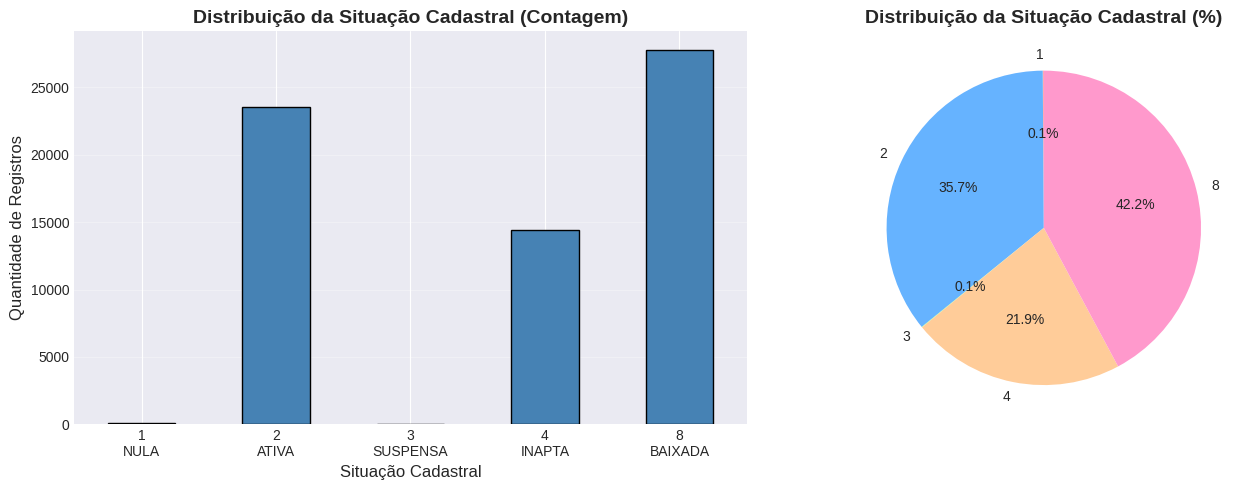


⚠️  Observação: Classes desbalanceadas detectadas!
   Classe 1 (NULA) tem apenas 72 registros (0.11%)
   Classe 3 (SUSPENSA) tem apenas 35 registros (0.05%)


In [31]:
# Análise da distribuição da situação cadastral
print("="*60)
print("ANÁLISE DA VARIÁVEL TARGET")
print("="*60)

# Mapeamento das situações cadastrais
situacao_map = {
    1: 'NULA',
    2: 'ATIVA',
    3: 'SUSPENSA',
    4: 'INAPTA',
    8: 'BAIXADA'
}

# Distribuição
distribuicao = df['situacao_cadastral'].value_counts().sort_index()
distribuicao_pct = df['situacao_cadastral'].value_counts(normalize=True).sort_index() * 100

print("\n📊 Distribuição da Situação Cadastral:")
print("-" * 60)
for situacao, count in distribuicao.items():
    pct = distribuicao_pct[situacao]
    nome = situacao_map.get(situacao, f'Desconhecida ({situacao})')
    print(f"  {situacao} - {nome:12s}: {count:6,} registros ({pct:5.2f}%)")

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
distribuicao.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Distribuição da Situação Cadastral (Contagem)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Situação Cadastral', fontsize=12)
axes[0].set_ylabel('Quantidade de Registros', fontsize=12)
axes[0].set_xticklabels([f"{k}\n{situacao_map.get(k, '?')}" for k in distribuicao.index], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Gráfico de pizza
distribuicao_pct.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90, 
                      colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc'])
axes[1].set_title('Distribuição da Situação Cadastral (%)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print(f"\n⚠️  Observação: Classes desbalanceadas detectadas!")
minority_classes = distribuicao[distribuicao < 100]
if len(minority_classes) > 0:
    for situacao, count in minority_classes.items():
        nome = situacao_map.get(situacao, f'Desconhecida ({situacao})')
        print(f"   Classe {situacao} ({nome}) tem apenas {count} registros ({distribuicao_pct[situacao]:.2f}%)")


ANÁLISE TEMPORAL DA SITUAÇÃO CADASTRAL


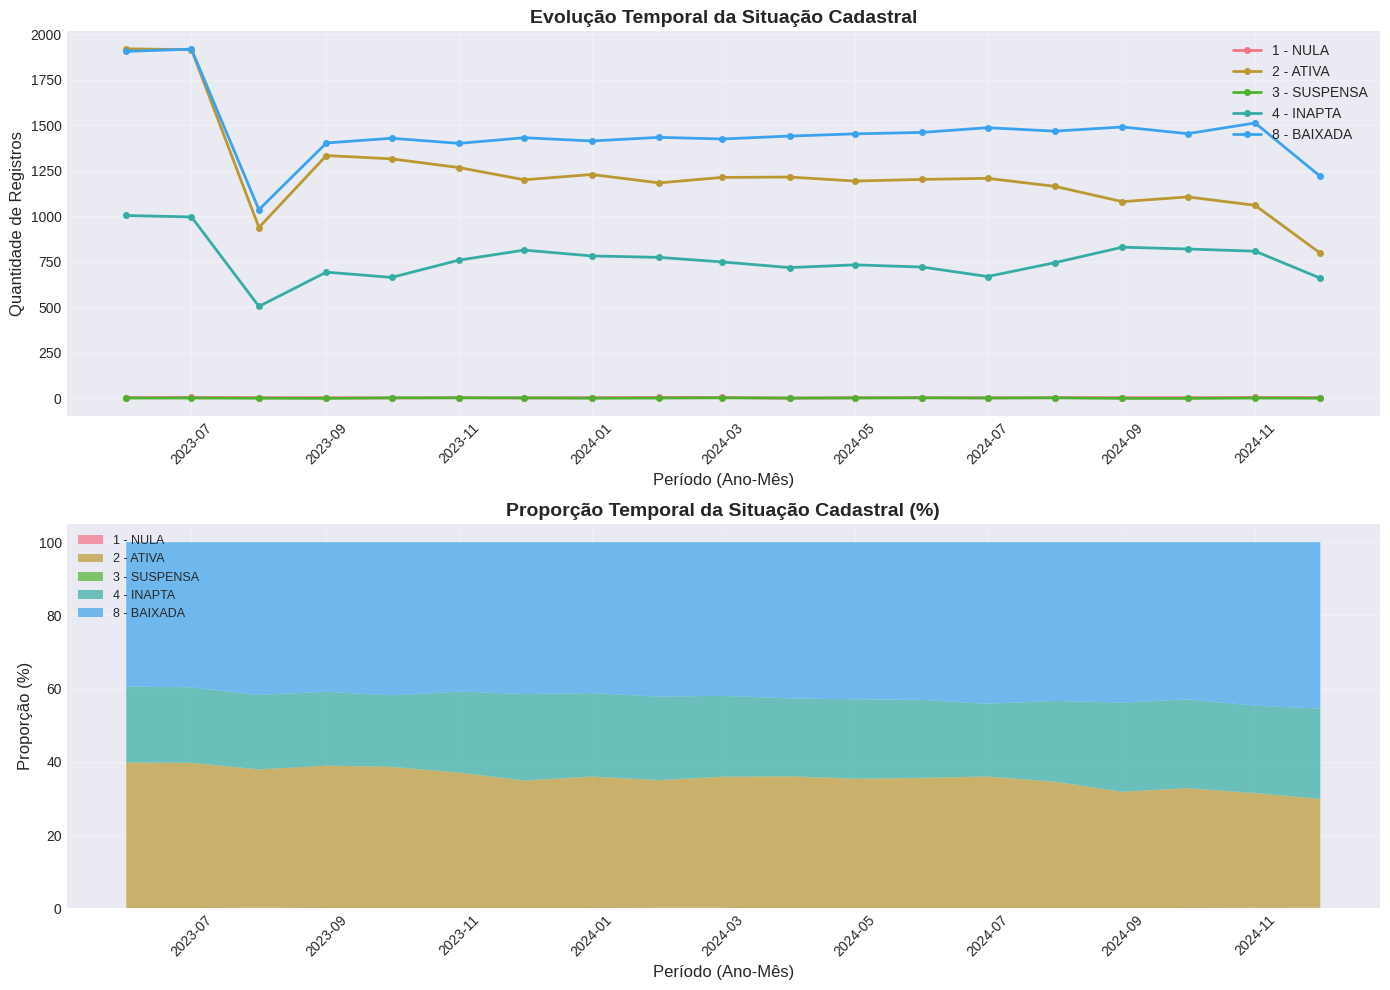

In [32]:
# Análise temporal da situação cadastral
print("="*60)
print("ANÁLISE TEMPORAL DA SITUAÇÃO CADASTRAL")
print("="*60)

# Agrupa por ano_mes e situação cadastral
temp_analysis = df.groupby(['ano_mes', 'situacao_cadastral']).size().unstack(fill_value=0)

# Visualização temporal
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Gráfico de linha temporal
for col in temp_analysis.columns:
    axes[0].plot(temp_analysis.index, temp_analysis[col], 
                marker='o', label=f"{col} - {situacao_map.get(col, '?')}", linewidth=2, markersize=4)
axes[0].set_title('Evolução Temporal da Situação Cadastral', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Período (Ano-Mês)', fontsize=12)
axes[0].set_ylabel('Quantidade de Registros', fontsize=12)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Gráfico de área empilhada (proporções)
temp_pct = temp_analysis.div(temp_analysis.sum(axis=1), axis=0) * 100
axes[1].stackplot(temp_pct.index, *[temp_pct[col] for col in temp_pct.columns],
                  labels=[f"{col} - {situacao_map.get(col, '?')}" for col in temp_pct.columns],
                  alpha=0.7)
axes[1].set_title('Proporção Temporal da Situação Cadastral (%)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Período (Ano-Mês)', fontsize=12)
axes[1].set_ylabel('Proporção (%)', fontsize=12)
axes[1].legend(loc='upper left', fontsize=9)
axes[1].grid(alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


ANÁLISE DAS VARIÁVEIS MACROECONÔMICAS


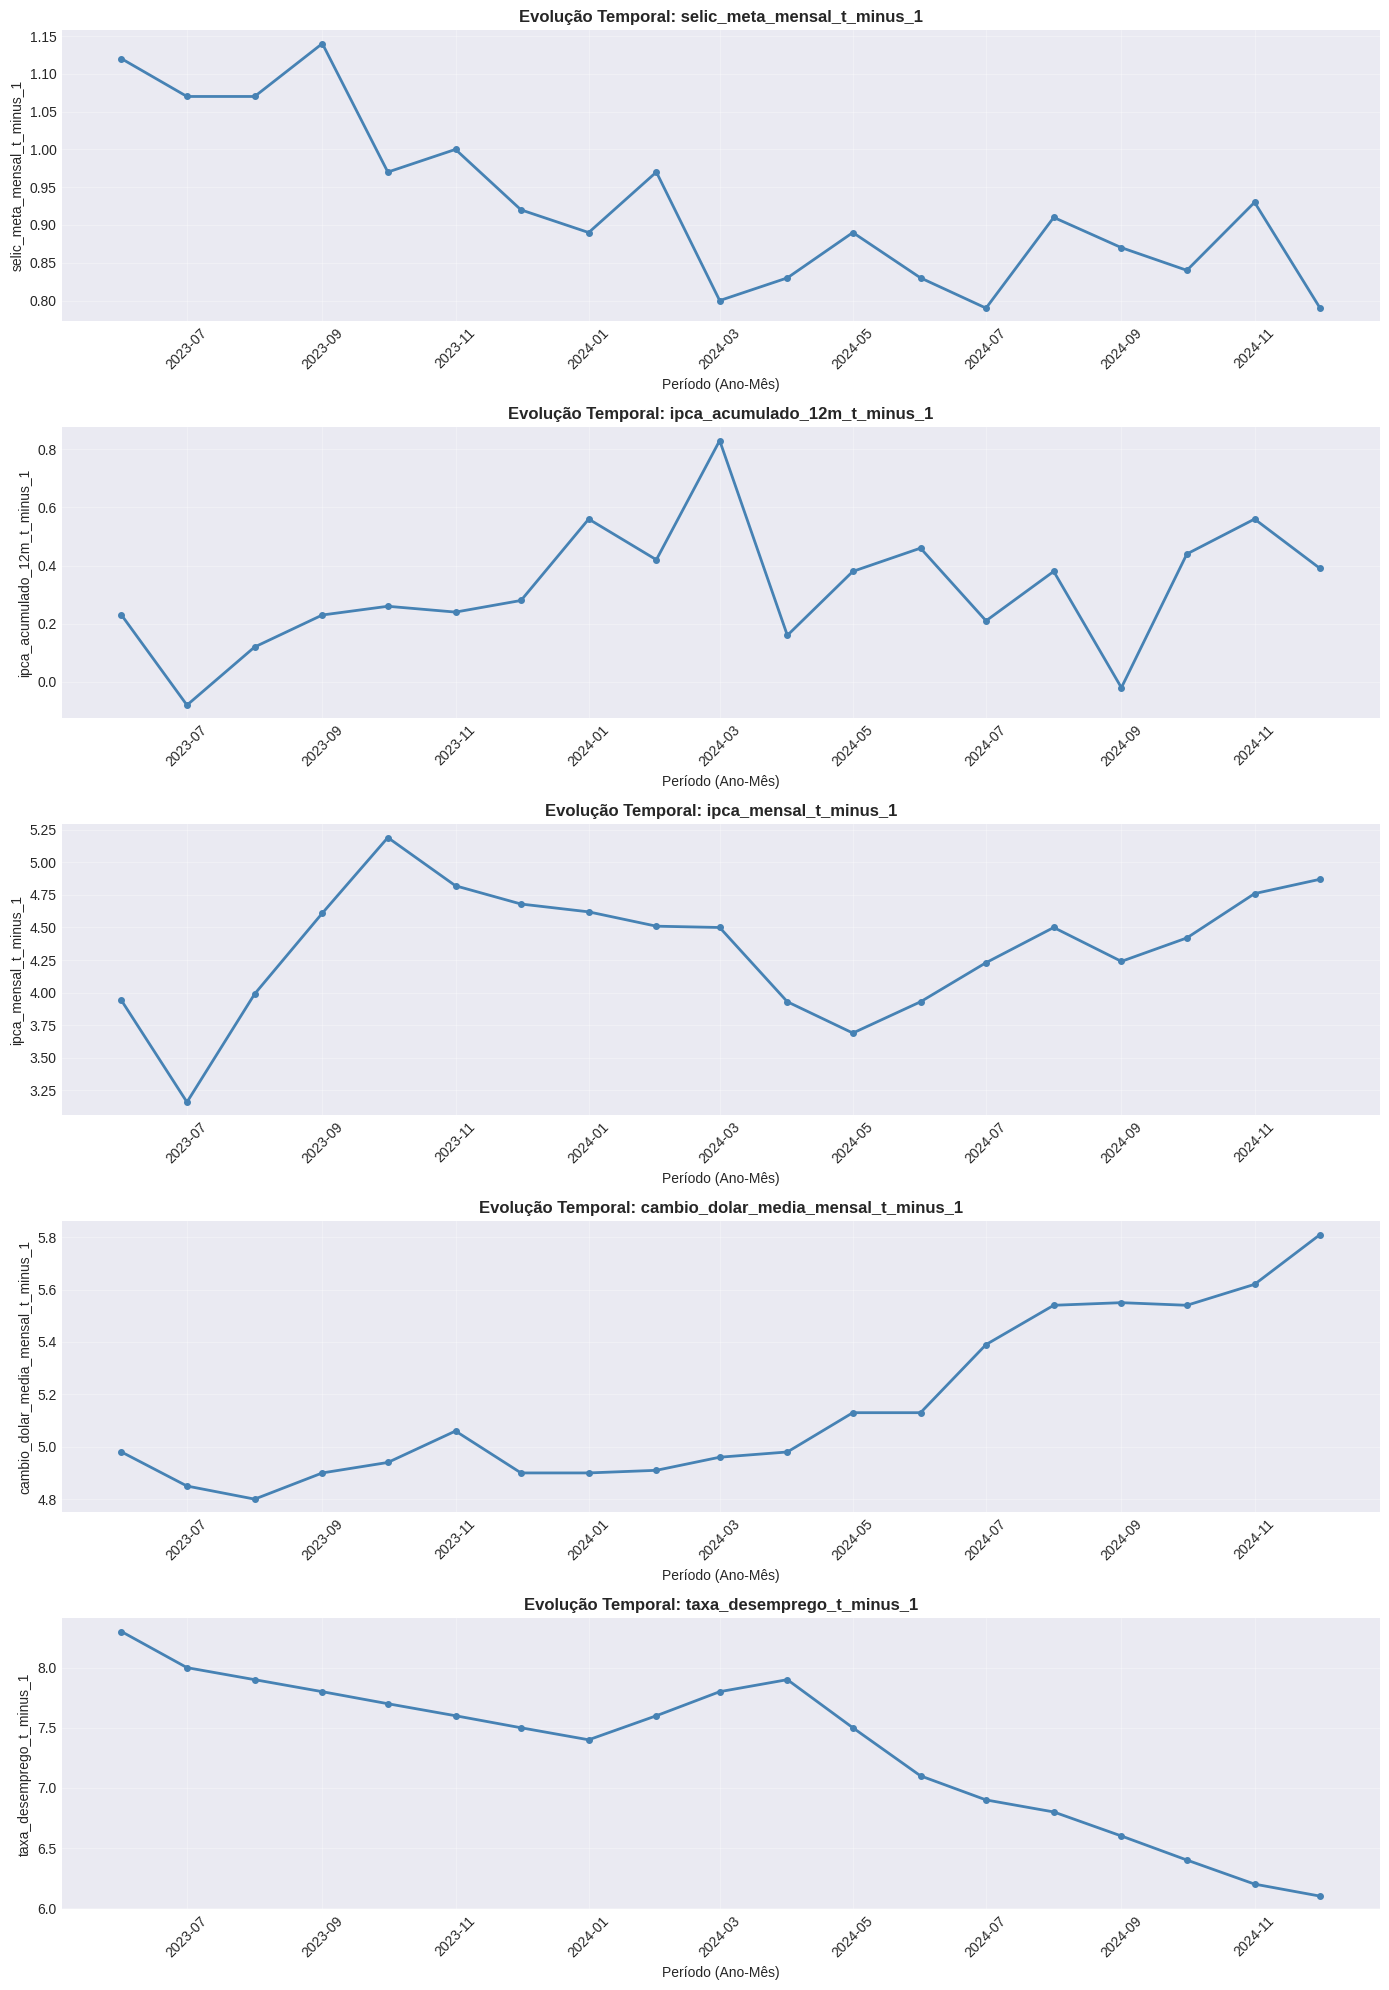


📊 Correlação entre Variáveis Macroeconômicas e Situação Cadastral:
------------------------------------------------------------
   cambio_dolar_media_mensal_t_minus_1          :  0.036
   ipca_mensal_t_minus_1                        :  0.016
   ipca_acumulado_12m_t_minus_1                 :  0.015
   selic_meta_mensal_t_minus_1                  : -0.032
   taxa_desemprego_t_minus_1                    : -0.039


In [33]:
# Análise das variáveis macroeconômicas ao longo do tempo
print("="*60)
print("ANÁLISE DAS VARIÁVEIS MACROECONÔMICAS")
print("="*60)

macro_vars = [
    'selic_meta_mensal_t_minus_1',
    'ipca_acumulado_12m_t_minus_1',
    'ipca_mensal_t_minus_1',
    'cambio_dolar_media_mensal_t_minus_1',
    'taxa_desemprego_t_minus_1'
]

# Agrupa por ano_mes e calcula média das variáveis macroeconômicas
macro_temporal = df.groupby('ano_mes')[macro_vars].mean()

# Visualização
fig, axes = plt.subplots(len(macro_vars), 1, figsize=(14, 4*len(macro_vars)))

for i, var in enumerate(macro_vars):
    if var in macro_temporal.columns:
        axes[i].plot(macro_temporal.index, macro_temporal[var], 
                    marker='o', linewidth=2, markersize=4, color='steelblue')
        axes[i].set_title(f'Evolução Temporal: {var}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Período (Ano-Mês)', fontsize=10)
        axes[i].set_ylabel(var, fontsize=10)
        axes[i].grid(alpha=0.3)
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Correlação entre variáveis macroeconômicas e situação cadastral por período
print("\n📊 Correlação entre Variáveis Macroeconômicas e Situação Cadastral:")
print("-" * 60)
macro_corr = df[macro_vars + ['situacao_cadastral']].corr()['situacao_cadastral'].drop('situacao_cadastral')
for var, corr in macro_corr.sort_values(ascending=False).items():
    print(f"   {var:45s}: {corr:6.3f}")


ANÁLISE DAS FEATURES NUMÉRICAS

Features numéricas disponíveis: 11
Colunas: ['tempo_atividade_anos', 'selic_meta_mensal_t_minus_1', 'ipca_acumulado_12m_t_minus_1', 'ipca_mensal_t_minus_1', 'cambio_dolar_media_mensal_t_minus_1', 'taxa_desemprego_t_minus_1', 'capital_social', 'pgfn_fgts_valor_acumulado_t_minus_1', 'pgfn_naoprev_valor_acumulado_t_minus_1', 'pgfn_prev_valor_acumulado_t_minus_1', 'pgfn_fgts_ajuizados_t_minus_1']


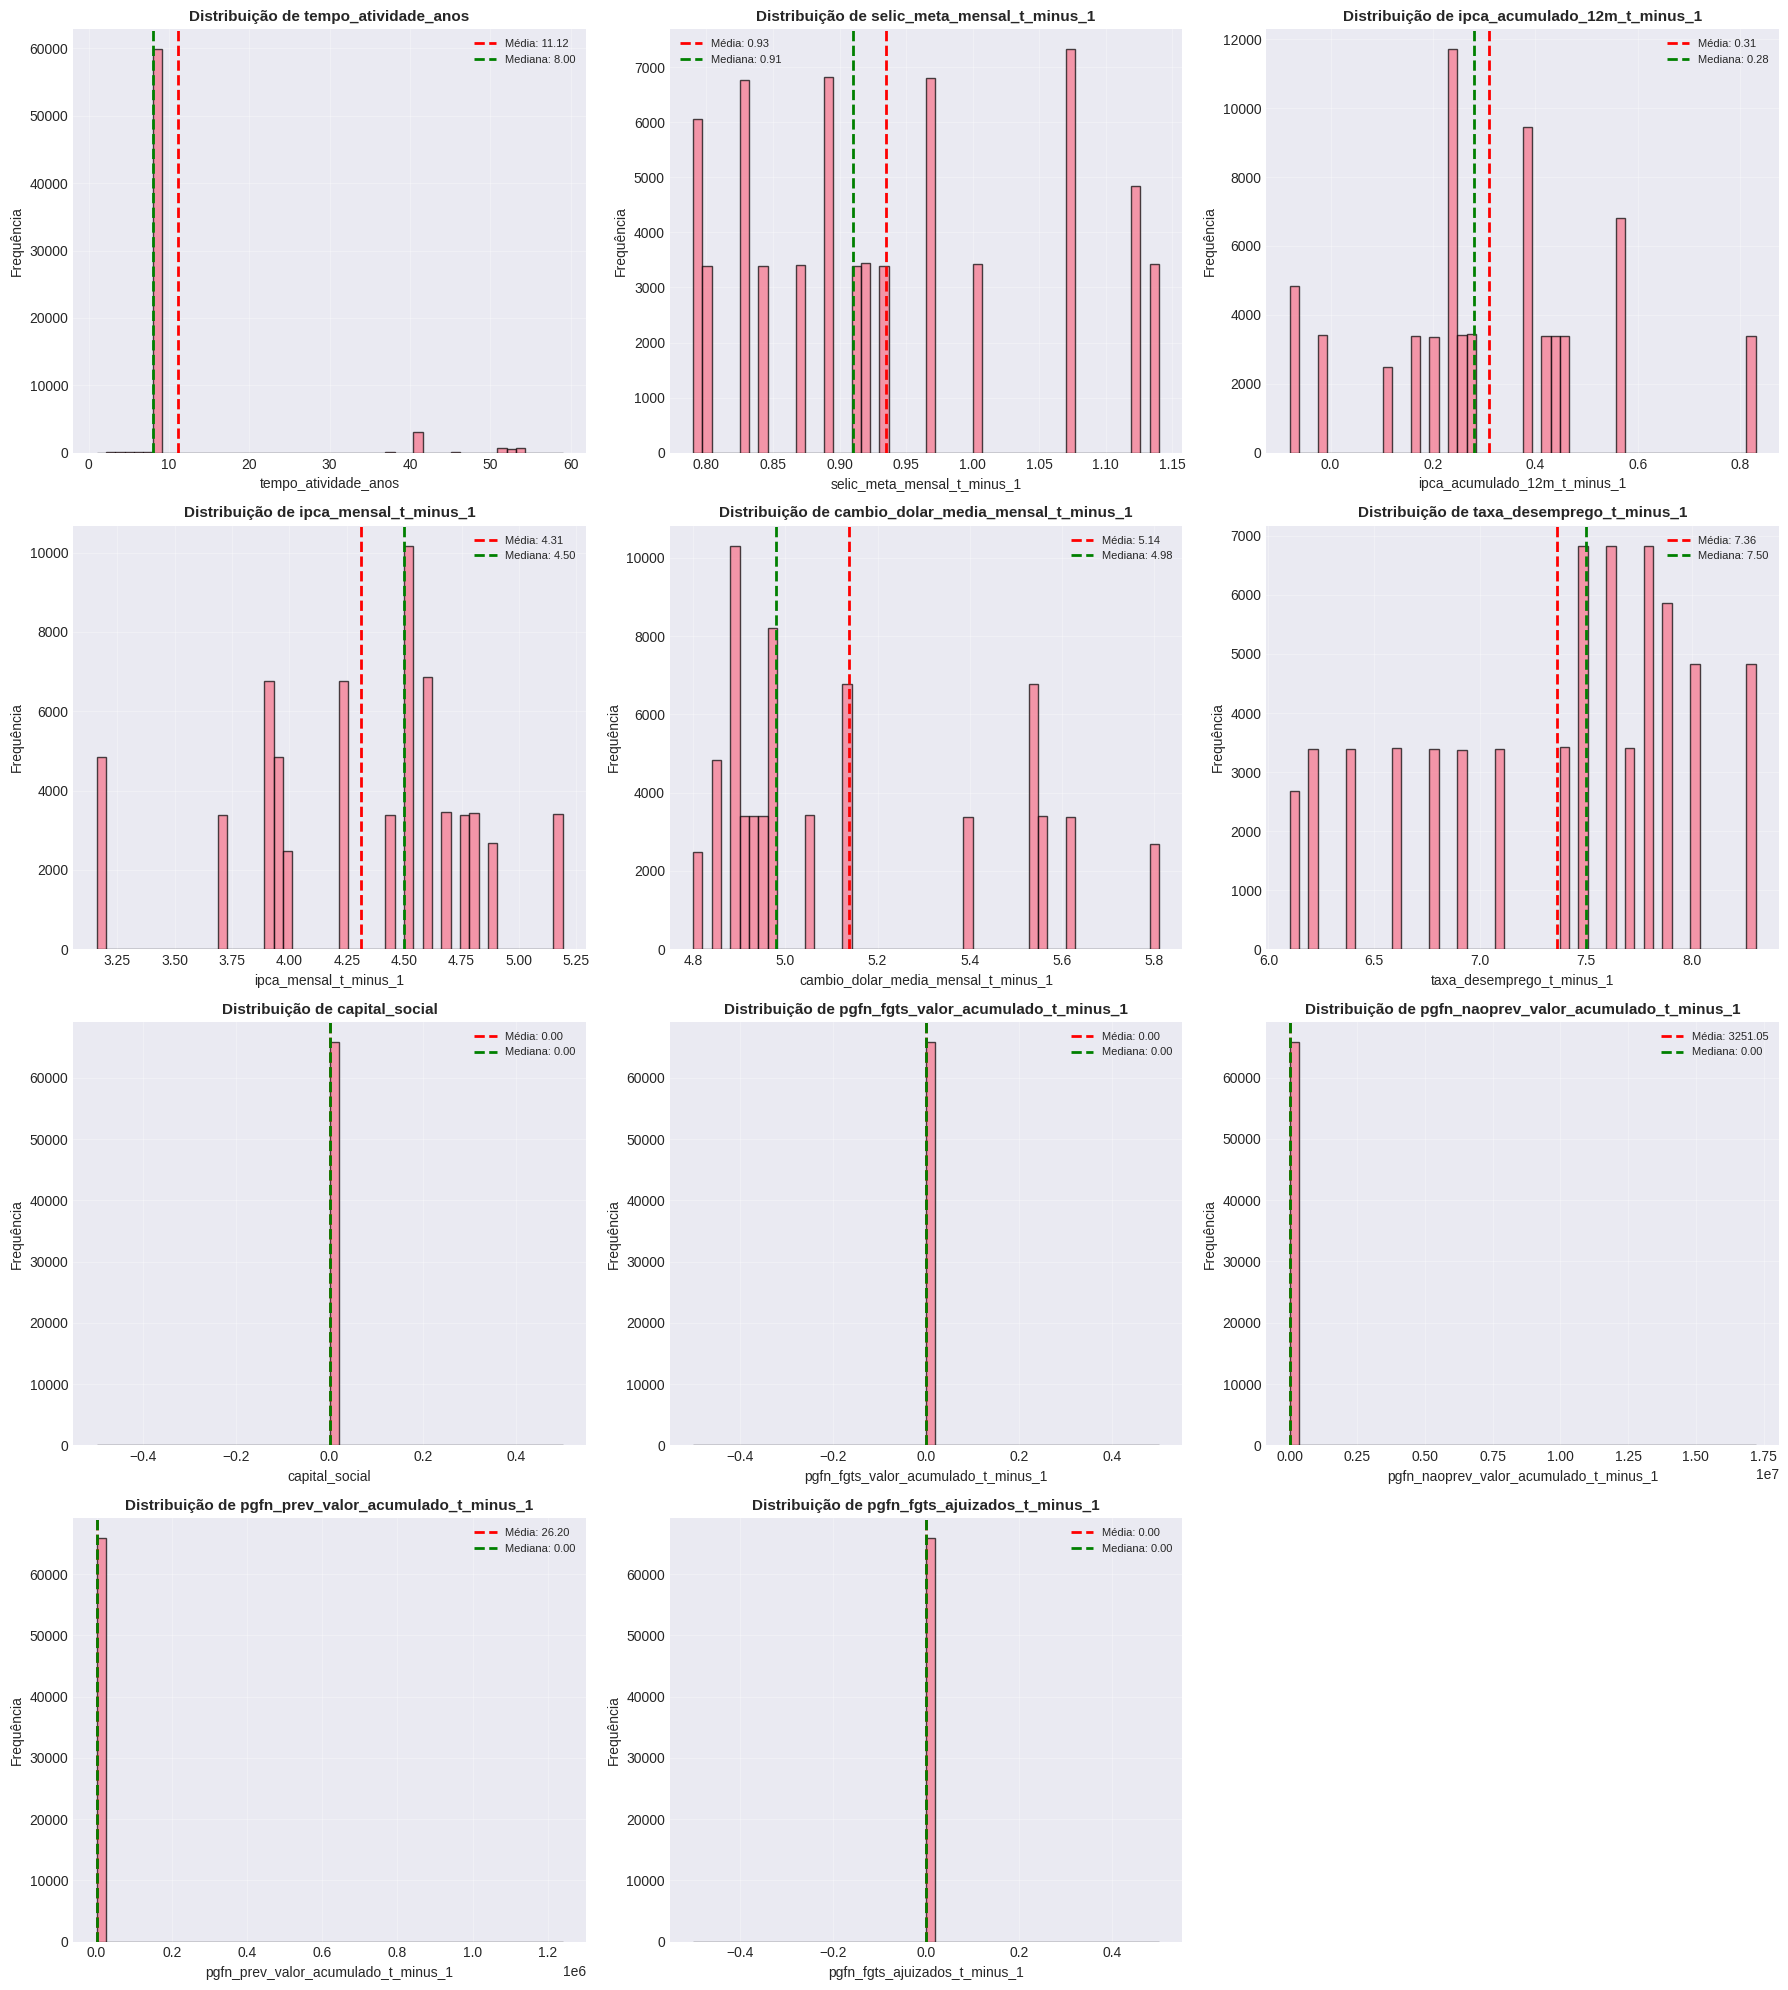


📈 Estatísticas Descritivas das Features Numéricas:
------------------------------------------------------------


,tempo_atividade_anos,selic_meta_mensal_t_minus_1,ipca_acumulado_12m_t_minus_1,ipca_mensal_t_minus_1,cambio_dolar_media_mensal_t_minus_1,taxa_desemprego_t_minus_1,capital_social,pgfn_fgts_valor_acumulado_t_minus_1,pgfn_naoprev_valor_acumulado_t_minus_1,pgfn_prev_valor_acumulado_t_minus_1,pgfn_fgts_ajuizados_t_minus_1
count,65855.000000,65855.000000,65855.000000,65855.000000,65855.000000,65855.000000,65855.0,65855.0,6.585500e+04,6.585500e+04,65855.0
mean,11.118366,0.934985,0.309690,4.312547,5.138700,7.363521,0.0,0.0,3.251053e+03,2.620258e+01,0.0
std,10.506744,0.109611,0.211838,0.496269,0.296659,0.629653,0.0,0.0,1.610831e+05,4.892588e+03,0.0
min,1.000000,0.790000,-0.080000,3.160000,4.800000,6.100000,0.0,0.0,0.000000e+00,0.000000e+00,0.0
25%,8.000000,0.840000,0.210000,3.940000,4.900000,6.900000,0.0,0.0,0.000000e+00,0.000000e+00,0.0
50%,8.000000,0.910000,0.280000,4.500000,4.980000,7.500000,0.0,0.0,0.000000e+00,0.000000e+00,0.0
75%,8.000000,1.000000,0.440000,4.620000,5.390000,7.800000,0.0,0.0,0.000000e+00,0.000000e+00,0.0
max,59.000000,1.140000,0.830000,5.190000,5.810000,8.300000,0.0,0.0,1.720541e+07,1.239464e+06,0.0


In [34]:
# Análise das features numéricas
print("="*60)
print("ANÁLISE DAS FEATURES NUMÉRICAS")
print("="*60)

numeric_cols = [
    'tempo_atividade_anos',
    'selic_meta_mensal_t_minus_1',
    'ipca_acumulado_12m_t_minus_1',
    'ipca_mensal_t_minus_1',
    'cambio_dolar_media_mensal_t_minus_1',
    'taxa_desemprego_t_minus_1',
    'capital_social',
    'pgfn_fgts_valor_acumulado_t_minus_1',
    'pgfn_naoprev_valor_acumulado_t_minus_1',
    'pgfn_prev_valor_acumulado_t_minus_1',
    'pgfn_fgts_ajuizados_t_minus_1'
]

# Filtra apenas colunas que existem
numeric_cols = [col for col in numeric_cols if col in df.columns]

print(f"\nFeatures numéricas disponíveis: {len(numeric_cols)}")
print(f"Colunas: {numeric_cols}")

# Visualização das distribuições
n_cols = len(numeric_cols)
n_rows = (n_cols + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    if col in df.columns:
        # Histograma
        df[col].hist(bins=50, ax=axes[i], edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Distribuição de {col}', fontsize=11, fontweight='bold')
        axes[i].set_xlabel(col, fontsize=10)
        axes[i].set_ylabel('Frequência', fontsize=10)
        axes[i].grid(alpha=0.3)
        
        # Estatísticas
        stats = df[col].describe()
        axes[i].axvline(stats['mean'], color='red', linestyle='--', linewidth=2, label=f'Média: {stats["mean"]:.2f}')
        axes[i].axvline(stats['50%'], color='green', linestyle='--', linewidth=2, label=f'Mediana: {stats["50%"]:.2f}')
        axes[i].legend(fontsize=8)

# Remove eixos extras
for i in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Estatísticas descritivas
print("\n📈 Estatísticas Descritivas das Features Numéricas:")
print("-" * 60)
df[numeric_cols].describe()


CORRELAÇÃO ENTRE FEATURES E TARGET


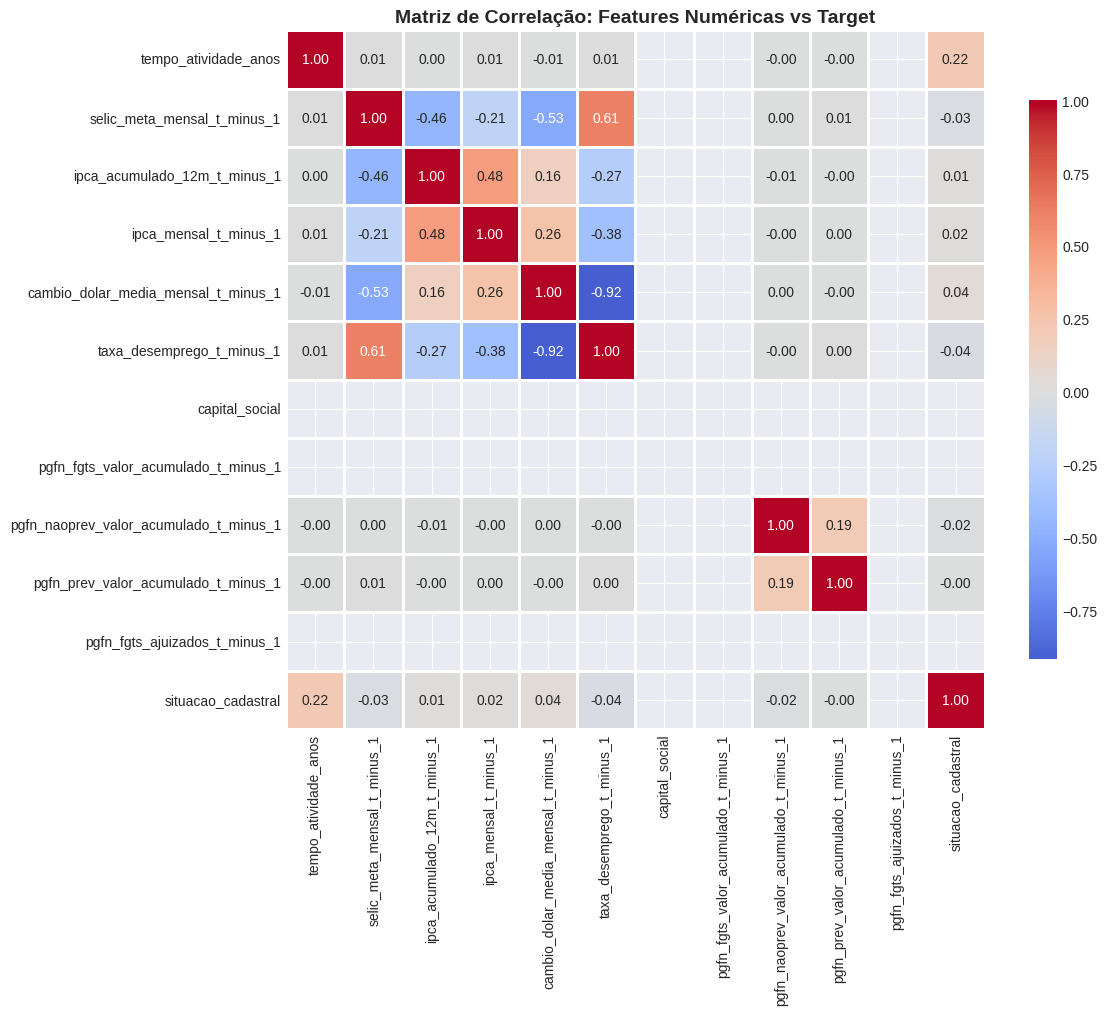


📊 Correlação das Features com Situação Cadastral:
------------------------------------------------------------
  tempo_atividade_anos                         :  0.218
  cambio_dolar_media_mensal_t_minus_1          :  0.036
  ipca_mensal_t_minus_1                        :  0.016
  ipca_acumulado_12m_t_minus_1                 :  0.015
  pgfn_prev_valor_acumulado_t_minus_1          : -0.005
  pgfn_naoprev_valor_acumulado_t_minus_1       : -0.018
  selic_meta_mensal_t_minus_1                  : -0.032
  taxa_desemprego_t_minus_1                    : -0.039
  capital_social                               :    nan
  pgfn_fgts_valor_acumulado_t_minus_1          :    nan
  pgfn_fgts_ajuizados_t_minus_1                :    nan


In [35]:
# Análise de correlação entre features numéricas e target
print("="*60)
print("CORRELAÇÃO ENTRE FEATURES E TARGET")
print("="*60)

# Calcula correlações
corr_data = df[numeric_cols + ['situacao_cadastral']].corr()

# Visualização
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Matriz de Correlação: Features Numéricas vs Target', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Correlação com target
print("\n📊 Correlação das Features com Situação Cadastral:")
print("-" * 60)
target_corr = corr_data['situacao_cadastral'].drop('situacao_cadastral').sort_values(ascending=False)
for feature, corr in target_corr.items():
    print(f"  {feature:45s}: {corr:6.3f}")


In [36]:
# Análise das features categóricas
print("="*60)
print("ANÁLISE DAS FEATURES CATEGÓRICAS")
print("="*60)

categorical_cols = ['cnae_fiscal_principal', 'uf', 'natureza_juridica', 'porte_empresa']

print("\n📊 Análise de CNAE Fiscal Principal:")
print(f"   Valores únicos: {df['cnae_fiscal_principal'].nunique()}")
print(f"   Top 10 CNAEs mais frequentes:")
print(df['cnae_fiscal_principal'].value_counts().head(10))

print("\n📊 Análise de UF:")
print(f"   Valores únicos: {df['uf'].nunique()}")
print(f"   Top 10 UFs mais frequentes:")
print(df['uf'].value_counts().head(10))

print("\n📊 Análise de Natureza Jurídica:")
print(f"   Valores únicos: {df['natureza_juridica'].nunique()}")
print(f"   Distribuição:")
print(df['natureza_juridica'].value_counts().head(10))

print("\n📊 Análise de Porte da Empresa:")
print(f"   Valores únicos: {df['porte_empresa'].nunique()}")
print(f"   Distribuição:")
print(df['porte_empresa'].value_counts().sort_index())


ANÁLISE DAS FEATURES CATEGÓRICAS

📊 Análise de CNAE Fiscal Principal:
   Valores únicos: 440
   Top 10 CNAEs mais frequentes:
cnae_fiscal_principal
4781400    4930
9602501    3604
4399103    2108
5611203    1979
8888888    1875
7319002    1692
5620104    1561
4321500    1189
4723700    1120
4712100    1095
Name: count, dtype: int64

📊 Análise de UF:
   Valores únicos: 28
   Top 10 UFs mais frequentes:
uf
SP    17914
RJ    14422
MG     6872
RS     3788
PR     3062
BA     2592
SC     2141
GO     1800
PE     1750
CE     1548
Name: count, dtype: int64

📊 Análise de Natureza Jurídica:
   Valores únicos: 25
   Distribuição:
natureza_juridica
2135    55820
2062     7893
3999      397
4120      274
2305      222
4014      190
2321      163
2240      118
2224      113
3085      104
Name: count, dtype: int64

📊 Análise de Porte da Empresa:
   Valores únicos: 3
   Distribuição:
porte_empresa
1.0    58496
3.0      872
5.0     6311
Name: count, dtype: int64


## 3. Análise das Features Disponíveis


ANÁLISE DAS FEATURES NUMÉRICAS

Features numéricas disponíveis: 11
Colunas: ['tempo_atividade_anos', 'selic_meta_mensal_t_minus_1', 'ipca_acumulado_12m_t_minus_1', 'ipca_mensal_t_minus_1', 'cambio_dolar_media_mensal_t_minus_1', 'taxa_desemprego_t_minus_1', 'capital_social', 'pgfn_fgts_valor_acumulado_t_minus_1', 'pgfn_naoprev_valor_acumulado_t_minus_1', 'pgfn_prev_valor_acumulado_t_minus_1', 'pgfn_fgts_ajuizados_t_minus_1']


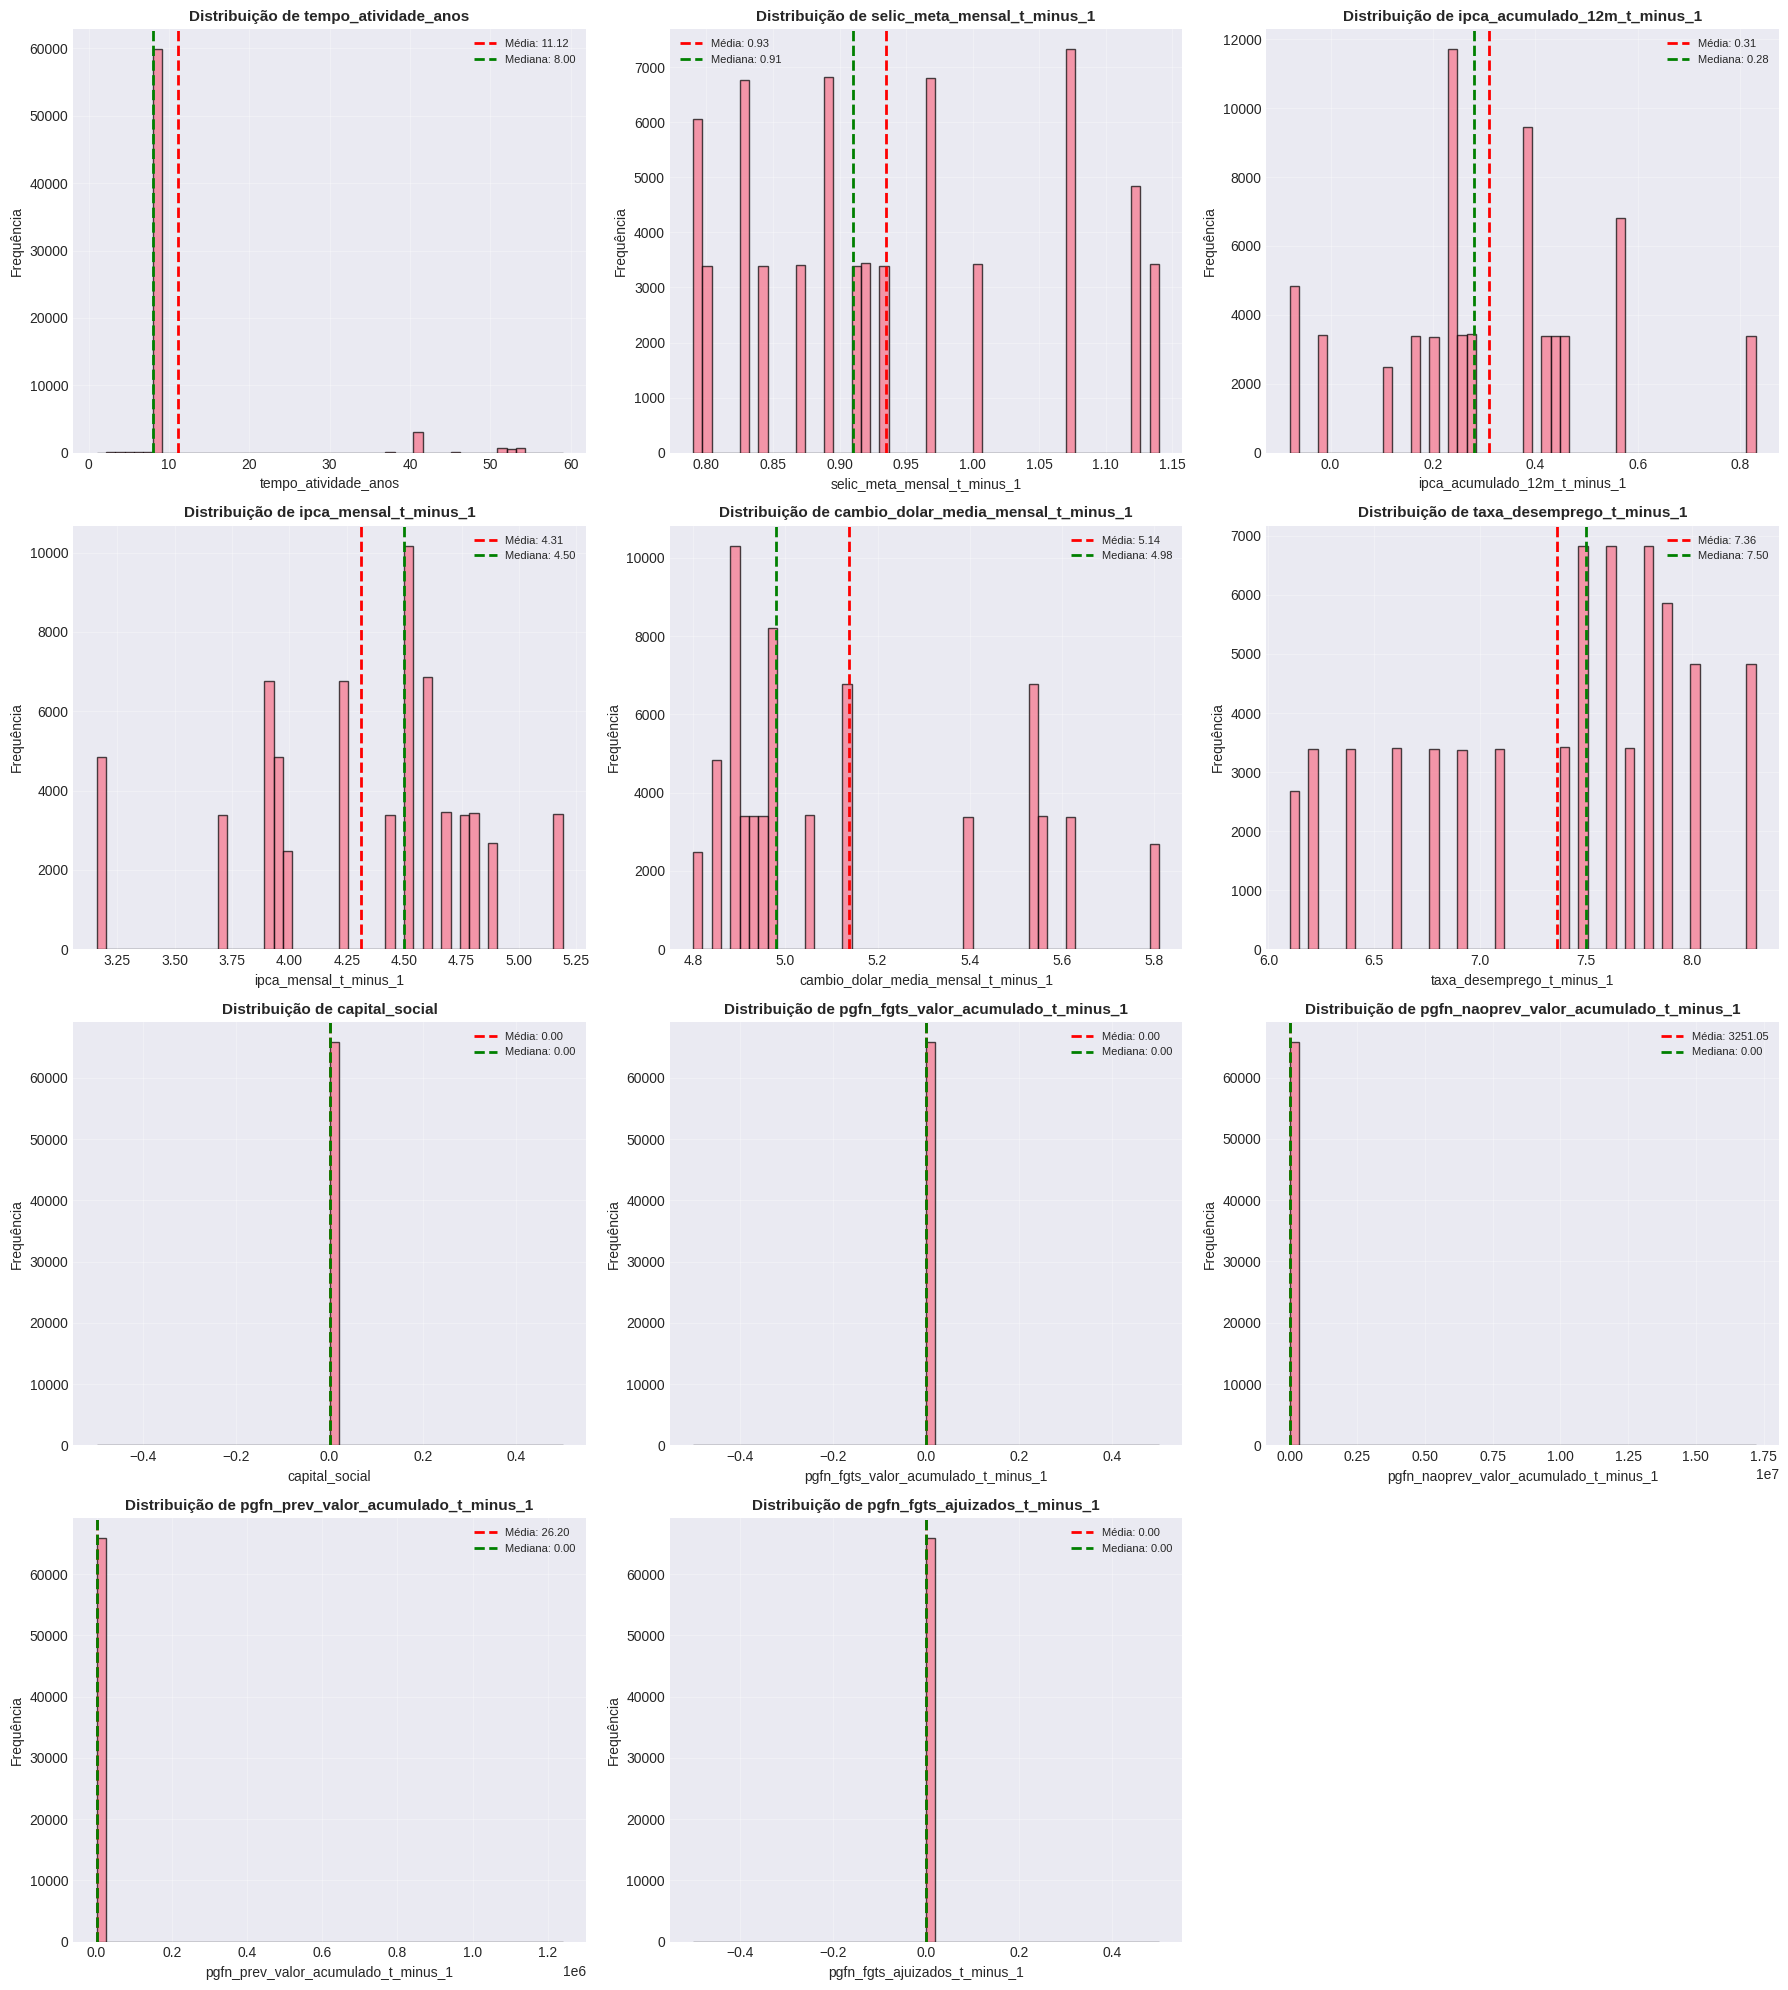


📈 Estatísticas Descritivas das Features Numéricas:
------------------------------------------------------------


,tempo_atividade_anos,selic_meta_mensal_t_minus_1,ipca_acumulado_12m_t_minus_1,ipca_mensal_t_minus_1,cambio_dolar_media_mensal_t_minus_1,taxa_desemprego_t_minus_1,capital_social,pgfn_fgts_valor_acumulado_t_minus_1,pgfn_naoprev_valor_acumulado_t_minus_1,pgfn_prev_valor_acumulado_t_minus_1,pgfn_fgts_ajuizados_t_minus_1
count,65855.000000,65855.000000,65855.000000,65855.000000,65855.000000,65855.000000,65855.0,65855.0,6.585500e+04,6.585500e+04,65855.0
mean,11.118366,0.934985,0.309690,4.312547,5.138700,7.363521,0.0,0.0,3.251053e+03,2.620258e+01,0.0
std,10.506744,0.109611,0.211838,0.496269,0.296659,0.629653,0.0,0.0,1.610831e+05,4.892588e+03,0.0
min,1.000000,0.790000,-0.080000,3.160000,4.800000,6.100000,0.0,0.0,0.000000e+00,0.000000e+00,0.0
25%,8.000000,0.840000,0.210000,3.940000,4.900000,6.900000,0.0,0.0,0.000000e+00,0.000000e+00,0.0
50%,8.000000,0.910000,0.280000,4.500000,4.980000,7.500000,0.0,0.0,0.000000e+00,0.000000e+00,0.0
75%,8.000000,1.000000,0.440000,4.620000,5.390000,7.800000,0.0,0.0,0.000000e+00,0.000000e+00,0.0
max,59.000000,1.140000,0.830000,5.190000,5.810000,8.300000,0.0,0.0,1.720541e+07,1.239464e+06,0.0


In [37]:
# Análise das features numéricas
print("="*60)
print("ANÁLISE DAS FEATURES NUMÉRICAS")
print("="*60)

numeric_cols = [
    'tempo_atividade_anos',
    'selic_meta_mensal_t_minus_1',
    'ipca_acumulado_12m_t_minus_1',
    'ipca_mensal_t_minus_1',
    'cambio_dolar_media_mensal_t_minus_1',
    'taxa_desemprego_t_minus_1',
    'capital_social',
    'pgfn_fgts_valor_acumulado_t_minus_1',
    'pgfn_naoprev_valor_acumulado_t_minus_1',
    'pgfn_prev_valor_acumulado_t_minus_1',
    'pgfn_fgts_ajuizados_t_minus_1'
]

# Filtra apenas colunas que existem
numeric_cols = [col for col in numeric_cols if col in df.columns]

print(f"\nFeatures numéricas disponíveis: {len(numeric_cols)}")
print(f"Colunas: {numeric_cols}")

# Visualização das distribuições
n_cols = len(numeric_cols)
n_rows = (n_cols + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    if col in df.columns:
        # Histograma
        df[col].hist(bins=50, ax=axes[i], edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Distribuição de {col}', fontsize=11, fontweight='bold')
        axes[i].set_xlabel(col, fontsize=10)
        axes[i].set_ylabel('Frequência', fontsize=10)
        axes[i].grid(alpha=0.3)
        
        # Estatísticas
        stats = df[col].describe()
        axes[i].axvline(stats['mean'], color='red', linestyle='--', linewidth=2, label=f'Média: {stats["mean"]:.2f}')
        axes[i].axvline(stats['50%'], color='green', linestyle='--', linewidth=2, label=f'Mediana: {stats["50%"]:.2f}')
        axes[i].legend(fontsize=8)

# Remove eixos extras
for i in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Estatísticas descritivas
print("\n📈 Estatísticas Descritivas das Features Numéricas:")
print("-" * 60)
df[numeric_cols].describe()


CORRELAÇÃO ENTRE FEATURES E TARGET


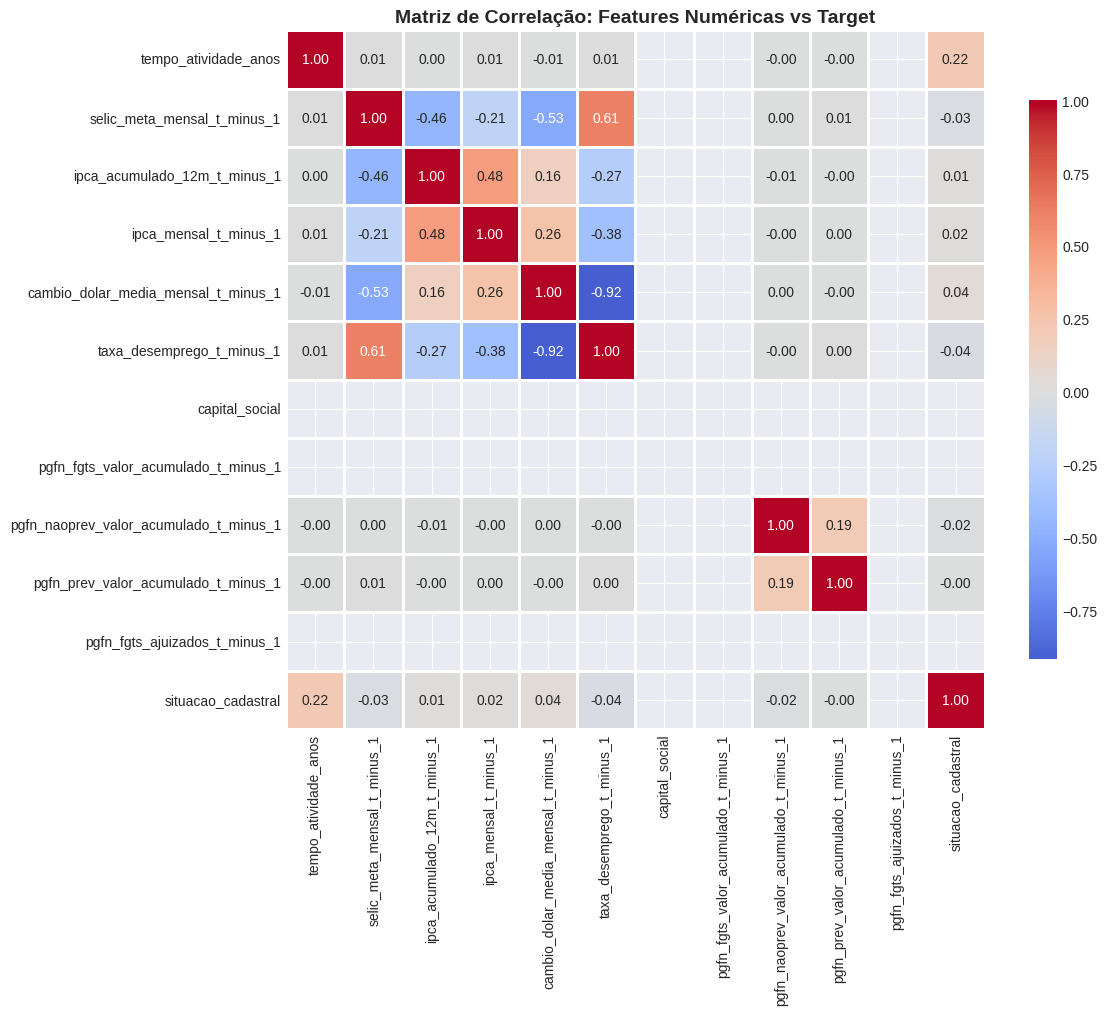


📊 Correlação das Features com Situação Cadastral:
------------------------------------------------------------
  tempo_atividade_anos                         :  0.218
  cambio_dolar_media_mensal_t_minus_1          :  0.036
  ipca_mensal_t_minus_1                        :  0.016
  ipca_acumulado_12m_t_minus_1                 :  0.015
  pgfn_prev_valor_acumulado_t_minus_1          : -0.005
  pgfn_naoprev_valor_acumulado_t_minus_1       : -0.018
  selic_meta_mensal_t_minus_1                  : -0.032
  taxa_desemprego_t_minus_1                    : -0.039
  capital_social                               :    nan
  pgfn_fgts_valor_acumulado_t_minus_1          :    nan
  pgfn_fgts_ajuizados_t_minus_1                :    nan


In [38]:
# Análise de correlação entre features numéricas e target
print("="*60)
print("CORRELAÇÃO ENTRE FEATURES E TARGET")
print("="*60)

# Calcula correlações
corr_data = df[numeric_cols + ['situacao_cadastral']].corr()

# Visualização
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Matriz de Correlação: Features Numéricas vs Target', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Correlação com target
print("\n📊 Correlação das Features com Situação Cadastral:")
print("-" * 60)
target_corr = corr_data['situacao_cadastral'].drop('situacao_cadastral').sort_values(ascending=False)
for feature, corr in target_corr.items():
    print(f"  {feature:45s}: {corr:6.3f}")


In [39]:
# Análise das features categóricas
print("="*60)
print("ANÁLISE DAS FEATURES CATEGÓRICAS")
print("="*60)

categorical_cols = ['cnae_fiscal_principal', 'uf', 'natureza_juridica', 'porte_empresa']

print("\n📊 Análise de CNAE Fiscal Principal:")
print(f"   Valores únicos: {df['cnae_fiscal_principal'].nunique()}")
print(f"   Top 10 CNAEs mais frequentes:")
print(df['cnae_fiscal_principal'].value_counts().head(10))

print("\n📊 Análise de UF:")
print(f"   Valores únicos: {df['uf'].nunique()}")
print(f"   Top 10 UFs mais frequentes:")
print(df['uf'].value_counts().head(10))

print("\n📊 Análise de Natureza Jurídica:")
print(f"   Valores únicos: {df['natureza_juridica'].nunique()}")
print(f"   Distribuição:")
print(df['natureza_juridica'].value_counts().head(10))

print("\n📊 Análise de Porte da Empresa:")
print(f"   Valores únicos: {df['porte_empresa'].nunique()}")
print(f"   Distribuição:")
print(df['porte_empresa'].value_counts().sort_index())


ANÁLISE DAS FEATURES CATEGÓRICAS

📊 Análise de CNAE Fiscal Principal:
   Valores únicos: 440
   Top 10 CNAEs mais frequentes:
cnae_fiscal_principal
4781400    4930
9602501    3604
4399103    2108
5611203    1979
8888888    1875
7319002    1692
5620104    1561
4321500    1189
4723700    1120
4712100    1095
Name: count, dtype: int64

📊 Análise de UF:
   Valores únicos: 28
   Top 10 UFs mais frequentes:
uf
SP    17914
RJ    14422
MG     6872
RS     3788
PR     3062
BA     2592
SC     2141
GO     1800
PE     1750
CE     1548
Name: count, dtype: int64

📊 Análise de Natureza Jurídica:
   Valores únicos: 25
   Distribuição:
natureza_juridica
2135    55820
2062     7893
3999      397
4120      274
2305      222
4014      190
2321      163
2240      118
2224      113
3085      104
Name: count, dtype: int64

📊 Análise de Porte da Empresa:
   Valores únicos: 3
   Distribuição:
porte_empresa
1.0    58496
3.0      872
5.0     6311
Name: count, dtype: int64


## 4. Criação de Features para o Modelo


In [40]:
# Função para criar features temporais
def create_temporal_features(df):
    """Cria features temporais a partir de ano_mes"""
    df = df.copy()
    df['ano'] = df['ano_mes'].dt.year
    df['mes'] = df['ano_mes'].dt.month
    df['trimestre'] = df['ano_mes'].dt.quarter
    df['semestre'] = (df['mes'] <= 6).astype(int) + 1
    df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)
    
    # Número de meses desde o início
    min_date = df['ano_mes'].min()
    df['meses_desde_inicio'] = (
        (df['ano_mes'].dt.year - min_date.year) * 12 + 
        (df['ano_mes'].dt.month - min_date.month)
    )
    return df

# Função para criar features de lag
def create_lag_features(df, lag_periods=[1, 2, 3, 6, 12]):
    """Cria features de lag para cada empresa"""
    df = df.sort_values(['cnpj', 'ano_mes']).reset_index(drop=True)
    
    for lag in lag_periods:
        df[f'situacao_cadastral_lag_{lag}'] = df.groupby('cnpj')['situacao_cadastral'].shift(lag)
    
    return df

# Função para criar features de rolling
def create_rolling_features(df, windows=[3, 6, 12]):
    """Cria features de rolling statistics por empresa"""
    df = df.sort_values(['cnpj', 'ano_mes']).reset_index(drop=True)
    
    for window in windows:
        df[f'situacao_cadastral_rolling_mean_{window}'] = (
            df.groupby('cnpj')['situacao_cadastral']
            .rolling(window=window, min_periods=1)
            .mean()
            .reset_index(0, drop=True)
        )
        df[f'situacao_cadastral_rolling_std_{window}'] = (
            df.groupby('cnpj')['situacao_cadastral']
            .rolling(window=window, min_periods=1)
            .std()
            .fillna(0)
            .reset_index(0, drop=True)
        )
    
    return df

# Função para criar features agregadas
def create_aggregated_features(df):
    """Cria features agregadas por empresa"""
    empresa_stats = df.groupby('cnpj').agg({
        'situacao_cadastral': ['mean', 'std', 'min', 'max', 'count'],
        'tempo_atividade_anos': 'first',
        'capital_social': 'first'
    }).reset_index()
    
    empresa_stats.columns = ['cnpj'] + [
        '_'.join(col).strip() if col[1] else col[0] 
        for col in empresa_stats.columns[1:]
    ]
    
    df = df.merge(empresa_stats, on='cnpj', suffixes=('', '_empresa'))
    
    df['posicao_temporal'] = df.groupby('cnpj').cumcount()
    df['total_registros_empresa'] = df.groupby('cnpj')['cnpj'].transform('count')
    df['posicao_relativa'] = df['posicao_temporal'] / df['total_registros_empresa']
    
    return df

print("✅ Funções de criação de features definidas!")


✅ Funções de criação de features definidas!


In [41]:
# Cria todas as features
print("Criando features temporais...")
df_features = create_temporal_features(df)

print("Criando features de lag...")
df_features = create_lag_features(df_features)

print("Criando features de rolling...")
df_features = create_rolling_features(df_features)

print("Criando features agregadas...")
df_features = create_aggregated_features(df_features)

print(f"\n✅ Features criadas! Shape: {df_features.shape}")
print(f"   Colunas adicionadas: {df_features.shape[1] - df.shape[1]}")

# Mostra algumas das novas features
new_features = [col for col in df_features.columns if col not in df.columns]
print(f"\n📋 Novas features criadas ({len(new_features)}):")
for i, feat in enumerate(new_features[:25], 1):
    print(f"   {i:2d}. {feat}")
if len(new_features) > 25:
    print(f"   ... e mais {len(new_features) - 25} features")


Criando features temporais...
Criando features de lag...
Criando features de rolling...
Criando features agregadas...

✅ Features criadas! Shape: (65855, 47)
   Colunas adicionadas: 28

📋 Novas features criadas (28):
    1. ano
    2. mes
    3. trimestre
    4. semestre
    5. mes_sin
    6. mes_cos
    7. meses_desde_inicio
    8. situacao_cadastral_lag_1
    9. situacao_cadastral_lag_2
   10. situacao_cadastral_lag_3
   11. situacao_cadastral_lag_6
   12. situacao_cadastral_lag_12
   13. situacao_cadastral_rolling_mean_3
   14. situacao_cadastral_rolling_std_3
   15. situacao_cadastral_rolling_mean_6
   16. situacao_cadastral_rolling_std_6
   17. situacao_cadastral_rolling_mean_12
   18. situacao_cadastral_rolling_std_12
   19. situacao_cadastral_mean
   20. situacao_cadastral_std
   21. situacao_cadastral_min
   22. situacao_cadastral_max
   23. situacao_cadastral_count
   24. tempo_atividade_anos_first
   25. capital_social_first
   ... e mais 3 features


## 5. Preparação dos Dados para Treinamento


In [42]:
# Seleciona features para o modelo
feature_cols = [
    # Temporais
    'ano', 'mes', 'trimestre', 'semestre', 
    'mes_sin', 'mes_cos', 'meses_desde_inicio',
    
    # Categóricas (serão codificadas)
    'cnae_fiscal_principal', 'uf', 'natureza_juridica', 'porte_empresa',
    
    # Numéricas base
    'tempo_atividade_anos',
    'situacao_cadastral_t_minus_1',
    
    # Variáveis macroeconômicas
    'selic_meta_mensal_t_minus_1',
    'ipca_acumulado_12m_t_minus_1',
    'ipca_mensal_t_minus_1',
    'cambio_dolar_media_mensal_t_minus_1',
    'taxa_desemprego_t_minus_1',
    
    # Dados de empresa
    'capital_social',
    
    # Dados PGFN
    'pgfn_fgts_valor_acumulado_t_minus_1',
    'pgfn_naoprev_valor_acumulado_t_minus_1',
    'pgfn_prev_valor_acumulado_t_minus_1',
    'pgfn_fgts_ajuizados_t_minus_1',
    
    # Lag features
    'situacao_cadastral_lag_1', 'situacao_cadastral_lag_2', 
    'situacao_cadastral_lag_3', 'situacao_cadastral_lag_6',
    
    # Rolling features
    'situacao_cadastral_rolling_mean_3',
    'situacao_cadastral_rolling_mean_6',
    'situacao_cadastral_rolling_mean_12',
    'situacao_cadastral_rolling_std_3',
    'situacao_cadastral_rolling_std_6',
    
    # Agregadas
    'posicao_relativa',
    'situacao_cadastral_mean_empresa',
    'situacao_cadastral_std_empresa',
]

# Filtra apenas colunas que existem
feature_cols = [col for col in feature_cols if col in df_features.columns]

# Remove linhas com NaN
df_clean = df_features.dropna(subset=feature_cols + ['situacao_cadastral']).copy()

print(f"📊 Dados após limpeza:")
print(f"   Registros: {len(df_clean):,} (removidos {len(df_features) - len(df_clean):,} com NaN)")
print(f"   Features selecionadas: {len(feature_cols)}")
print(f"\n📋 Features selecionadas:")
for i, feat in enumerate(feature_cols, 1):
    print(f"   {i:2d}. {feat}")


📊 Dados após limpeza:
   Registros: 36,737 (removidos 29,118 com NaN)
   Features selecionadas: 33

📋 Features selecionadas:
    1. ano
    2. mes
    3. trimestre
    4. semestre
    5. mes_sin
    6. mes_cos
    7. meses_desde_inicio
    8. cnae_fiscal_principal
    9. uf
   10. natureza_juridica
   11. porte_empresa
   12. tempo_atividade_anos
   13. situacao_cadastral_t_minus_1
   14. selic_meta_mensal_t_minus_1
   15. ipca_acumulado_12m_t_minus_1
   16. ipca_mensal_t_minus_1
   17. cambio_dolar_media_mensal_t_minus_1
   18. taxa_desemprego_t_minus_1
   19. capital_social
   20. pgfn_fgts_valor_acumulado_t_minus_1
   21. pgfn_naoprev_valor_acumulado_t_minus_1
   22. pgfn_prev_valor_acumulado_t_minus_1
   23. pgfn_fgts_ajuizados_t_minus_1
   24. situacao_cadastral_lag_1
   25. situacao_cadastral_lag_2
   26. situacao_cadastral_lag_3
   27. situacao_cadastral_lag_6
   28. situacao_cadastral_rolling_mean_3
   29. situacao_cadastral_rolling_mean_6
   30. situacao_cadastral_rolling_mean

In [43]:
# Prepara dados categóricos
print("="*60)
print("PREPARAÇÃO DE FEATURES CATEGÓRICAS")
print("="*60)

# Limpa e converte categóricas
categorical_cols = ['cnae_fiscal_principal', 'uf', 'natureza_juridica', 'porte_empresa']
categorical_cols = [col for col in categorical_cols if col in df_clean.columns]

for col in categorical_cols:
    df_clean[col] = df_clean[col].astype(str).str.replace(r"\[|\]|'", '', regex=True)
    df_clean[col] = df_clean[col].str.strip()

# Análise das categorias
for col in categorical_cols:
    print(f"\n📊 Análise de {col}:")
    print(f"   Valores únicos: {df_clean[col].nunique()}")
    print(f"   Top 10 valores mais frequentes:")
    print(df_clean[col].value_counts().head(10))


PREPARAÇÃO DE FEATURES CATEGÓRICAS

📊 Análise de cnae_fiscal_principal:
   Valores únicos: 438
   Top 10 valores mais frequentes:
cnae_fiscal_principal
4781400    2766
9602501    2015
4399103    1185
5611203    1119
8888888    1089
7319002     945
5620104     862
4321500     666
4723700     620
4712100     606
Name: count, dtype: int64

📊 Análise de uf:
   Valores únicos: 27
   Top 10 valores mais frequentes:
uf
SP    9916
RJ    8231
MG    3837
RS    2096
PR    1679
BA    1444
SC    1196
GO     993
PE     991
CE     866
Name: count, dtype: int64

📊 Análise de natureza_juridica:
   Valores únicos: 23
   Top 10 valores mais frequentes:
natureza_juridica
2135    31205
2062     4436
3999      223
4120      154
2305      120
4014      106
2321       91
2224       65
2240       64
3085       56
Name: count, dtype: int64

📊 Análise de porte_empresa:
   Valores únicos: 3
   Top 10 valores mais frequentes:
porte_empresa
1.0    32650
5.0     3605
3.0      482
Name: count, dtype: int64


SEPARAÇÃO TREINO/VALIDAÇÃO/TESTE (TEMPORAL)
📊 Divisão dos dados:
   Treino:     25,715 registros (70.0%)
   Validação:  7,348 registros (20.0%)
   Teste:      3,674 registros (10.0%)

📊 Distribuição do target:

   TREINO:
situacao_cadastral
1       26
2     8260
3        6
4     5953
8    11470
Name: count, dtype: int64

   VALIDAÇÃO:
situacao_cadastral
1       9
2    2657
3       6
4    1609
8    3067
Name: count, dtype: int64

   TESTE:
situacao_cadastral
1       8
2    1422
4     712
8    1532
Name: count, dtype: int64


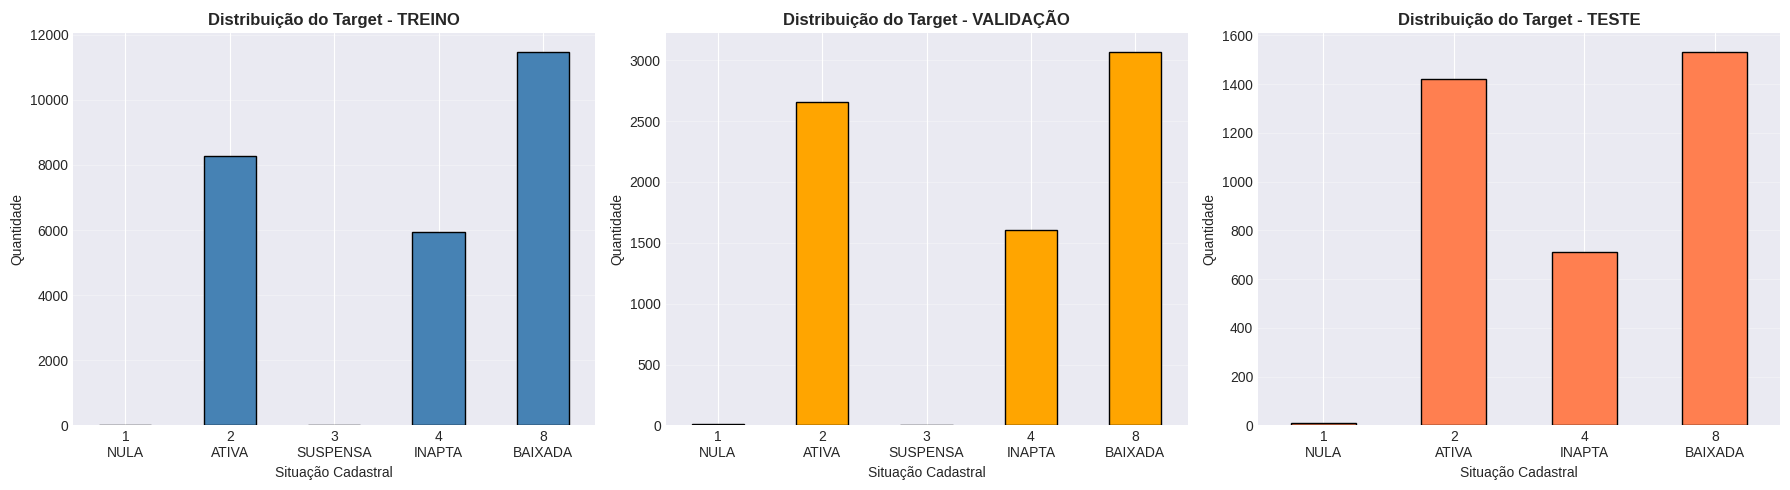

In [44]:
# Separação treino/validação/teste (temporal)
print("="*60)
print("SEPARAÇÃO TREINO/VALIDAÇÃO/TESTE (TEMPORAL)")
print("="*60)

# Usa 70% para treino, 20% para validação, 10% para teste (mantendo ordem temporal)
split_train_idx = int(len(df_clean) * 0.7)
split_val_idx = int(len(df_clean) * 0.9)

X_train = df_clean.iloc[:split_train_idx][feature_cols].copy()
X_val = df_clean.iloc[split_train_idx:split_val_idx][feature_cols].copy()
X_test = df_clean.iloc[split_val_idx:][feature_cols].copy()

y_train = df_clean.iloc[:split_train_idx]['situacao_cadastral'].copy()
y_val = df_clean.iloc[split_train_idx:split_val_idx]['situacao_cadastral'].copy()
y_test = df_clean.iloc[split_val_idx:]['situacao_cadastral'].copy()

print(f"📊 Divisão dos dados:")
print(f"   Treino:     {len(X_train):,} registros ({len(X_train)/len(df_clean)*100:.1f}%)")
print(f"   Validação:  {len(X_val):,} registros ({len(X_val)/len(df_clean)*100:.1f}%)")
print(f"   Teste:      {len(X_test):,} registros ({len(X_test)/len(df_clean)*100:.1f}%)")

# Distribuição do target em treino, validação e teste
print(f"\n📊 Distribuição do target:")
print(f"\n   TREINO:")
print(y_train.value_counts().sort_index())
print(f"\n   VALIDAÇÃO:")
print(y_val.value_counts().sort_index())
print(f"\n   TESTE:")
print(y_test.value_counts().sort_index())

# Visualização
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

y_train.value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Distribuição do Target - TREINO', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Situação Cadastral', fontsize=10)
axes[0].set_ylabel('Quantidade', fontsize=10)
axes[0].set_xticklabels([f"{k}\n{situacao_map.get(k, '?')}" for k in y_train.value_counts().sort_index().index], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

y_val.value_counts().sort_index().plot(kind='bar', ax=axes[1], color='orange', edgecolor='black')
axes[1].set_title('Distribuição do Target - VALIDAÇÃO', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Situação Cadastral', fontsize=10)
axes[1].set_ylabel('Quantidade', fontsize=10)
axes[1].set_xticklabels([f"{k}\n{situacao_map.get(k, '?')}" for k in y_val.value_counts().sort_index().index], rotation=0)
axes[1].grid(axis='y', alpha=0.3)

y_test.value_counts().sort_index().plot(kind='bar', ax=axes[2], color='coral', edgecolor='black')
axes[2].set_title('Distribuição do Target - TESTE', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Situação Cadastral', fontsize=10)
axes[2].set_ylabel('Quantidade', fontsize=10)
axes[2].set_xticklabels([f"{k}\n{situacao_map.get(k, '?')}" for k in y_test.value_counts().sort_index().index], rotation=0)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [45]:
# Codifica features categóricas
print("="*60)
print("CODIFICAÇÃO DE FEATURES CATEGÓRICAS")
print("="*60)

categorical_encoders = {}

for col in categorical_cols:
    if col in X_train.columns:
        # Pega todos os valores únicos de treino, validação e teste
        all_values = pd.concat([X_train[col], X_val[col], X_test[col]]).astype(str).unique()
        le = LabelEncoder()
        le.fit(all_values)
        categorical_encoders[col] = le
        
        X_train[col + '_encoded'] = le.transform(X_train[col].astype(str))
        X_val[col + '_encoded'] = le.transform(X_val[col].astype(str))
        X_test[col + '_encoded'] = le.transform(X_test[col].astype(str))
        
        # Remove coluna original
        X_train = X_train.drop(col, axis=1)
        X_val = X_val.drop(col, axis=1)
        X_test = X_test.drop(col, axis=1)
        
        # Atualiza feature_cols
        feature_cols = [c for c in feature_cols if c != col] + [col + '_encoded']
        
        print(f"✅ {col} codificado: {len(le.classes_)} valores únicos")

# Preenche NaN com 0
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

# Garante que todas as features estão presentes
X_train = X_train[feature_cols]
X_val = X_val[feature_cols]
X_test = X_test[feature_cols]

print(f"\n✅ Features finais: {len(feature_cols)}")
print(f"   Shape X_train: {X_train.shape}")
print(f"   Shape X_val:   {X_val.shape}")
print(f"   Shape X_test:  {X_test.shape}")


CODIFICAÇÃO DE FEATURES CATEGÓRICAS
✅ cnae_fiscal_principal codificado: 438 valores únicos
✅ uf codificado: 27 valores únicos
✅ natureza_juridica codificado: 23 valores únicos
✅ porte_empresa codificado: 3 valores únicos

✅ Features finais: 33
   Shape X_train: (25715, 33)
   Shape X_val:   (7348, 33)
   Shape X_test:  (3674, 33)


## 6. Treinamento do Modelo


In [46]:
# Treina modelo Random Forest
print("="*60)
print("TREINAMENTO DO MODELO")
print("="*60)

# Calcula pesos das classes para balanceamento
class_counts = y_train.value_counts()
total = len(y_train)
class_weights = {cls: total / (len(class_counts) * count) for cls, count in class_counts.items()}

print(f"\n⚖️  Pesos das classes para balanceamento:")
for cls, weight in sorted(class_counts.items()):
    nome = situacao_map.get(cls, f'Desconhecida ({cls})')
    print(f"   Classe {cls} ({nome:12s}): {class_counts[cls]:6,} registros, peso: {class_weights[cls]:.4f}")

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight=class_weights,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n🔄 Treinando modelo...")
model.fit(X_train, y_train)
print("✅ Modelo treinado!")

# Faz previsões em validação e teste
print("\n📊 Fazendo previsões...")
y_pred_val = model.predict(X_val)
y_pred_proba_val = model.predict_proba(X_val)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print(f"   Previsões em validação: {len(y_pred_val)} registros")
print(f"   Previsões em teste:     {len(y_pred)} registros")


TREINAMENTO DO MODELO

⚖️  Pesos das classes para balanceamento:
   Classe 1 (NULA        ):     26 registros, peso: 197.8077
   Classe 2 (ATIVA       ):  8,260 registros, peso: 0.6226
   Classe 3 (SUSPENSA    ):      6 registros, peso: 857.1667
   Classe 4 (INAPTA      ):  5,953 registros, peso: 0.8639
   Classe 8 (BAIXADA     ): 11,470 registros, peso: 0.4484

🔄 Treinando modelo...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s


✅ Modelo treinado!

📊 Fazendo previsões...
   Previsões em validação: 7348 registros
   Previsões em teste:     3674 registros


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend

## 7. Avaliação do Modelo


In [47]:
# Calcula métricas
print("="*60)
print("MÉTRICAS DE AVALIAÇÃO")
print("="*60)

# Métricas no conjunto de VALIDAÇÃO
print(f"\n📊 MÉTRICAS NO CONJUNTO DE VALIDAÇÃO:")
print("-" * 60)
accuracy_val = accuracy_score(y_val, y_pred_val)
f1_macro_val = f1_score(y_val, y_pred_val, average='macro')
f1_weighted_val = f1_score(y_val, y_pred_val, average='weighted')
precision_macro_val = precision_score(y_val, y_pred_val, average='macro')
recall_macro_val = recall_score(y_val, y_pred_val, average='macro')

print(f"   Acurácia:        {accuracy_val:.4f} ({accuracy_val*100:.2f}%)")
print(f"   F1-Score (macro): {f1_macro_val:.4f}")
print(f"   F1-Score (weighted): {f1_weighted_val:.4f}")
print(f"   Precisão (macro): {precision_macro_val:.4f}")
print(f"   Recall (macro):   {recall_macro_val:.4f}")

# Métricas no conjunto de TESTE
print(f"\n📊 MÉTRICAS NO CONJUNTO DE TESTE:")
print("-" * 60)
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"   Acurácia:        {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   F1-Score (macro): {f1_macro:.4f}")
print(f"   F1-Score (weighted): {f1_weighted:.4f}")
print(f"   Precisão (macro): {precision_macro:.4f}")
print(f"   Recall (macro):   {recall_macro:.4f}")

# Classification Report - VALIDAÇÃO
print(f"\n📋 Classification Report - VALIDAÇÃO:")
print("-" * 60)
print(classification_report(y_val, y_pred_val, 
                            target_names=[f"{k}-{situacao_map.get(k, '?')}" for k in sorted(y_val.unique())]))

# Classification Report - TESTE
print(f"\n📋 Classification Report - TESTE:")
print("-" * 60)
print(classification_report(y_test, y_pred, 
                            target_names=[f"{k}-{situacao_map.get(k, '?')}" for k in sorted(y_test.unique())]))

# Confusion Matrix - VALIDAÇÃO
cm_val = confusion_matrix(y_val, y_pred_val)
print(f"\n📊 Matriz de Confusão - VALIDAÇÃO:")
print("-" * 60)
print(cm_val)

# Confusion Matrix - TESTE
cm = confusion_matrix(y_test, y_pred)
print(f"\n📊 Matriz de Confusão - TESTE:")
print("-" * 60)
print(cm)


MÉTRICAS DE AVALIAÇÃO

📊 MÉTRICAS NO CONJUNTO DE VALIDAÇÃO:
------------------------------------------------------------
   Acurácia:        0.9993 (99.93%)
   F1-Score (macro): 0.9995
   F1-Score (weighted): 0.9993
   Precisão (macro): 0.9994
   Recall (macro):   0.9996

📊 MÉTRICAS NO CONJUNTO DE TESTE:
------------------------------------------------------------
   Acurácia:        0.9992 (99.92%)
   F1-Score (macro): 0.9992
   F1-Score (weighted): 0.9992
   Precisão (macro): 0.9990
   Recall (macro):   0.9995

📋 Classification Report - VALIDAÇÃO:
------------------------------------------------------------
              precision    recall  f1-score   support

      1-NULA       1.00      1.00      1.00         9
     2-ATIVA       1.00      1.00      1.00      2657
  3-SUSPENSA       1.00      1.00      1.00         6
    4-INAPTA       1.00      1.00      1.00      1609
   8-BAIXADA       1.00      1.00      1.00      3067

    accuracy                           1.00      7348
   

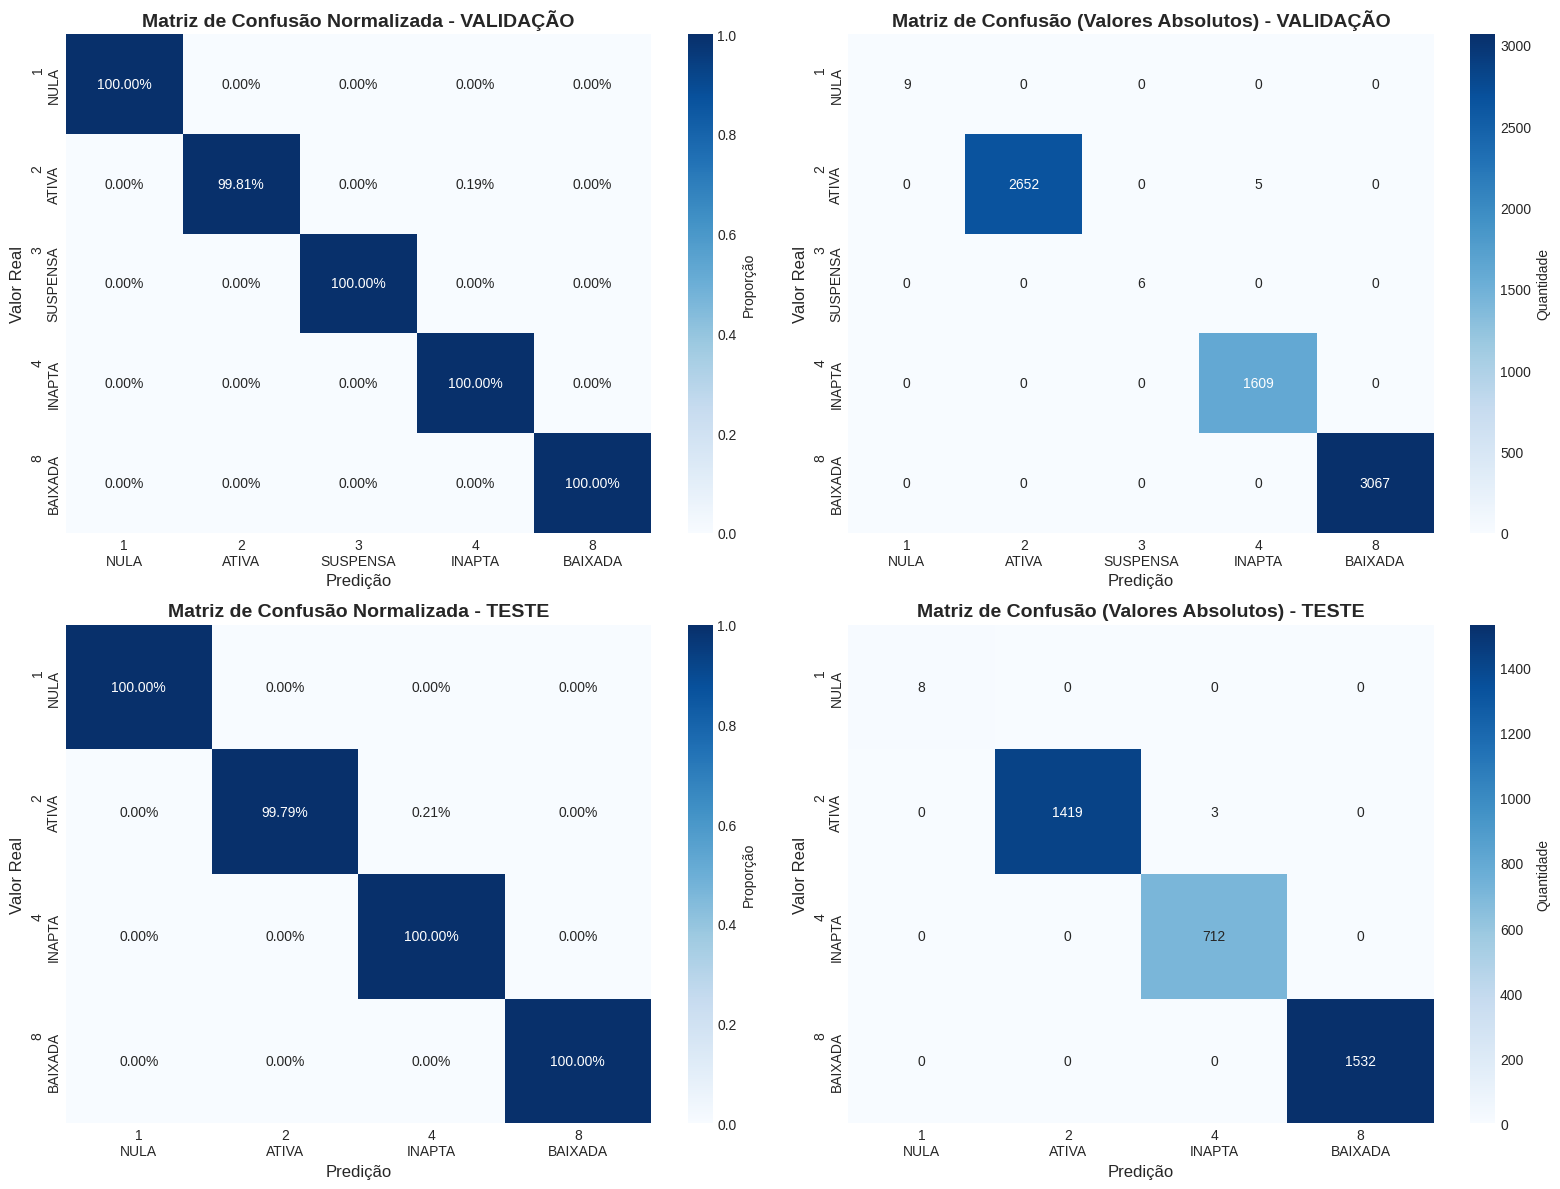

In [48]:
# Visualização das Matrizes de Confusão
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# VALIDAÇÃO - Normalizada
cm_val_normalized = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_val_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=[f"{k}\n{situacao_map.get(k, '?')}" for k in sorted(y_val.unique())],
            yticklabels=[f"{k}\n{situacao_map.get(k, '?')}" for k in sorted(y_val.unique())],
            ax=axes[0, 0], cbar_kws={'label': 'Proporção'})
axes[0, 0].set_title('Matriz de Confusão Normalizada - VALIDAÇÃO', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Predição', fontsize=12)
axes[0, 0].set_ylabel('Valor Real', fontsize=12)

# VALIDAÇÃO - Valores Absolutos
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"{k}\n{situacao_map.get(k, '?')}" for k in sorted(y_val.unique())],
            yticklabels=[f"{k}\n{situacao_map.get(k, '?')}" for k in sorted(y_val.unique())],
            ax=axes[0, 1], cbar_kws={'label': 'Quantidade'})
axes[0, 1].set_title('Matriz de Confusão (Valores Absolutos) - VALIDAÇÃO', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Predição', fontsize=12)
axes[0, 1].set_ylabel('Valor Real', fontsize=12)

# TESTE - Normalizada
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=[f"{k}\n{situacao_map.get(k, '?')}" for k in sorted(y_test.unique())],
            yticklabels=[f"{k}\n{situacao_map.get(k, '?')}" for k in sorted(y_test.unique())],
            ax=axes[1, 0], cbar_kws={'label': 'Proporção'})
axes[1, 0].set_title('Matriz de Confusão Normalizada - TESTE', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Predição', fontsize=12)
axes[1, 0].set_ylabel('Valor Real', fontsize=12)

# TESTE - Valores Absolutos
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"{k}\n{situacao_map.get(k, '?')}" for k in sorted(y_test.unique())],
            yticklabels=[f"{k}\n{situacao_map.get(k, '?')}" for k in sorted(y_test.unique())],
            ax=axes[1, 1], cbar_kws={'label': 'Quantidade'})
axes[1, 1].set_title('Matriz de Confusão (Valores Absolutos) - TESTE', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Predição', fontsize=12)
axes[1, 1].set_ylabel('Valor Real', fontsize=12)

plt.tight_layout()
plt.show()


## 8. Análise de Importância das Features


IMPORTÂNCIA DAS FEATURES

📊 Top 30 Features Mais Importantes:
----------------------------------------------------------------------
   24. situacao_cadastral_rolling_mean_3            : 0.1499
   20. situacao_cadastral_lag_1                     : 0.1367
   25. situacao_cadastral_rolling_mean_6            : 0.1311
    9. situacao_cadastral_t_minus_1                 : 0.1289
   21. situacao_cadastral_lag_2                     : 0.1183
   26. situacao_cadastral_rolling_mean_12           : 0.0913
   22. situacao_cadastral_lag_3                     : 0.0892
   23. situacao_cadastral_lag_6                     : 0.0629
   30. cnae_fiscal_principal_encoded                : 0.0263
   31. uf_encoded                                   : 0.0169
    6. mes_cos                                      : 0.0070
   29. posicao_relativa                             : 0.0050
   28. situacao_cadastral_rolling_std_6             : 0.0048
    2. mes                                          : 0.0048
   27. situac

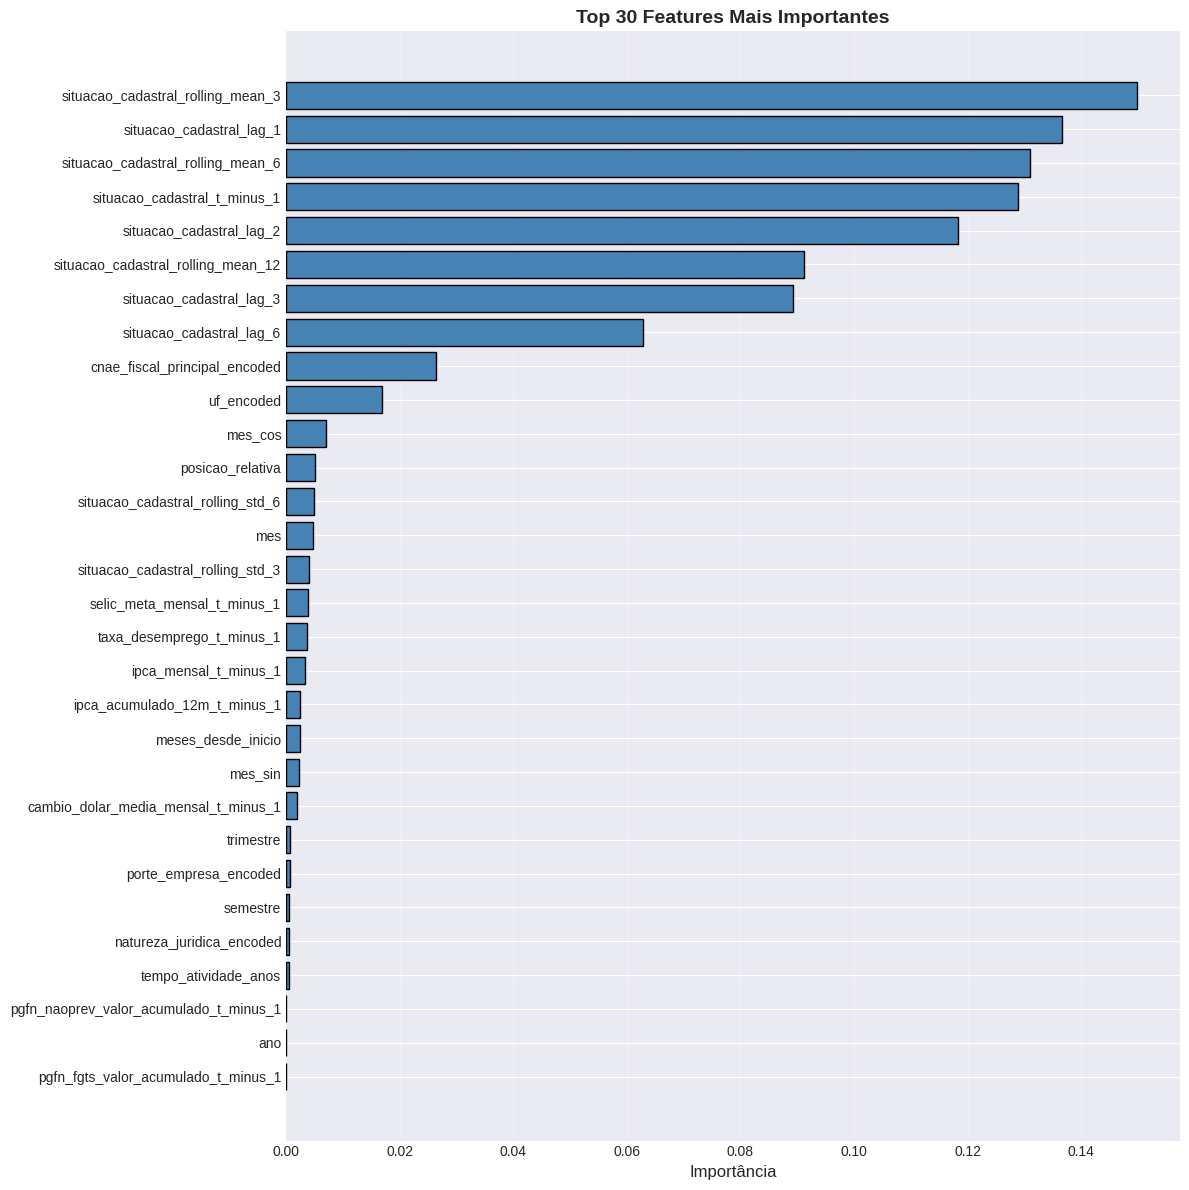


📊 Importância por Categoria de Features:
----------------------------------------------------------------------
   Temporais           : 0.0177 (7 features)
   Categóricas         : 0.0445 (4 features)
   Macroeconômicas     : 0.0152 (5 features)
   PGFN                : 0.0000 (4 features)
   Lag                 : 0.4071 (4 features)
   Rolling             : 0.3811 (5 features)
   Empresa             : 0.1293 (3 features)
   Agregadas           : 0.0057 (2 features)


In [49]:
# Importância das features
print("="*60)
print("IMPORTÂNCIA DAS FEATURES")
print("="*60)

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n📊 Top 30 Features Mais Importantes:")
print("-" * 70)
for i, row in feature_importance.head(30).iterrows():
    print(f"   {i+1:2d}. {row['feature']:45s}: {row['importance']:.4f}")

# Visualização
fig, ax = plt.subplots(figsize=(12, 12))
top_n = 30
top_features = feature_importance.head(top_n)

ax.barh(range(len(top_features)), top_features['importance'], color='steelblue', edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'], fontsize=10)
ax.set_xlabel('Importância', fontsize=12)
ax.set_title(f'Top {top_n} Features Mais Importantes', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

# Análise por categoria de features
print(f"\n📊 Importância por Categoria de Features:")
print("-" * 70)

categories = {
    'Temporais': ['ano', 'mes', 'trimestre', 'semestre', 'mes_sin', 'mes_cos', 'meses_desde_inicio'],
    'Categóricas': [c for c in feature_cols if '_encoded' in c],
    'Macroeconômicas': ['selic_meta_mensal_t_minus_1', 'ipca_acumulado_12m_t_minus_1', 
                        'ipca_mensal_t_minus_1', 'cambio_dolar_media_mensal_t_minus_1', 
                        'taxa_desemprego_t_minus_1'],
    'PGFN': ['pgfn_fgts_valor_acumulado_t_minus_1', 'pgfn_naoprev_valor_acumulado_t_minus_1',
             'pgfn_prev_valor_acumulado_t_minus_1', 'pgfn_fgts_ajuizados_t_minus_1'],
    'Lag': [c for c in feature_cols if 'lag' in c],
    'Rolling': [c for c in feature_cols if 'rolling' in c],
    'Empresa': ['tempo_atividade_anos', 'capital_social', 'situacao_cadastral_t_minus_1'],
    'Agregadas': [c for c in feature_cols if 'empresa' in c or 'posicao' in c]
}

for category, features in categories.items():
    cat_features = [f for f in features if f in feature_importance['feature'].values]
    if cat_features:
        cat_importance = feature_importance[feature_importance['feature'].isin(cat_features)]['importance'].sum()
        print(f"   {category:20s}: {cat_importance:.4f} ({len(cat_features)} features)")


## 9. Análise de Erros do Modelo


ANÁLISE DE ERROS

📊 Resumo de Erros - VALIDAÇÃO:
   Total de previsões: 7,348
   Acertos:            7,343 (99.93%)
   Erros:              5 (0.07%)

📊 Resumo de Erros - TESTE:
   Total de previsões: 3,674
   Acertos:            3,671 (99.92%)
   Erros:              3 (0.08%)

📊 Erros por Classe Real - VALIDAÇÃO:
------------------------------------------------------------
        Total_Erros  Taxa_Erro  Total_Registros  Taxa_Acerto
y_true                                                      
1                 0     0.0000                9       1.0000
2                 5     0.0019             2657       0.9981
3                 0     0.0000                6       1.0000
4                 0     0.0000             1609       1.0000
8                 0     0.0000             3067       1.0000

📊 Erros por Classe Real - TESTE:
------------------------------------------------------------
        Total_Erros  Taxa_Erro  Total_Registros  Taxa_Acerto
y_true                                   

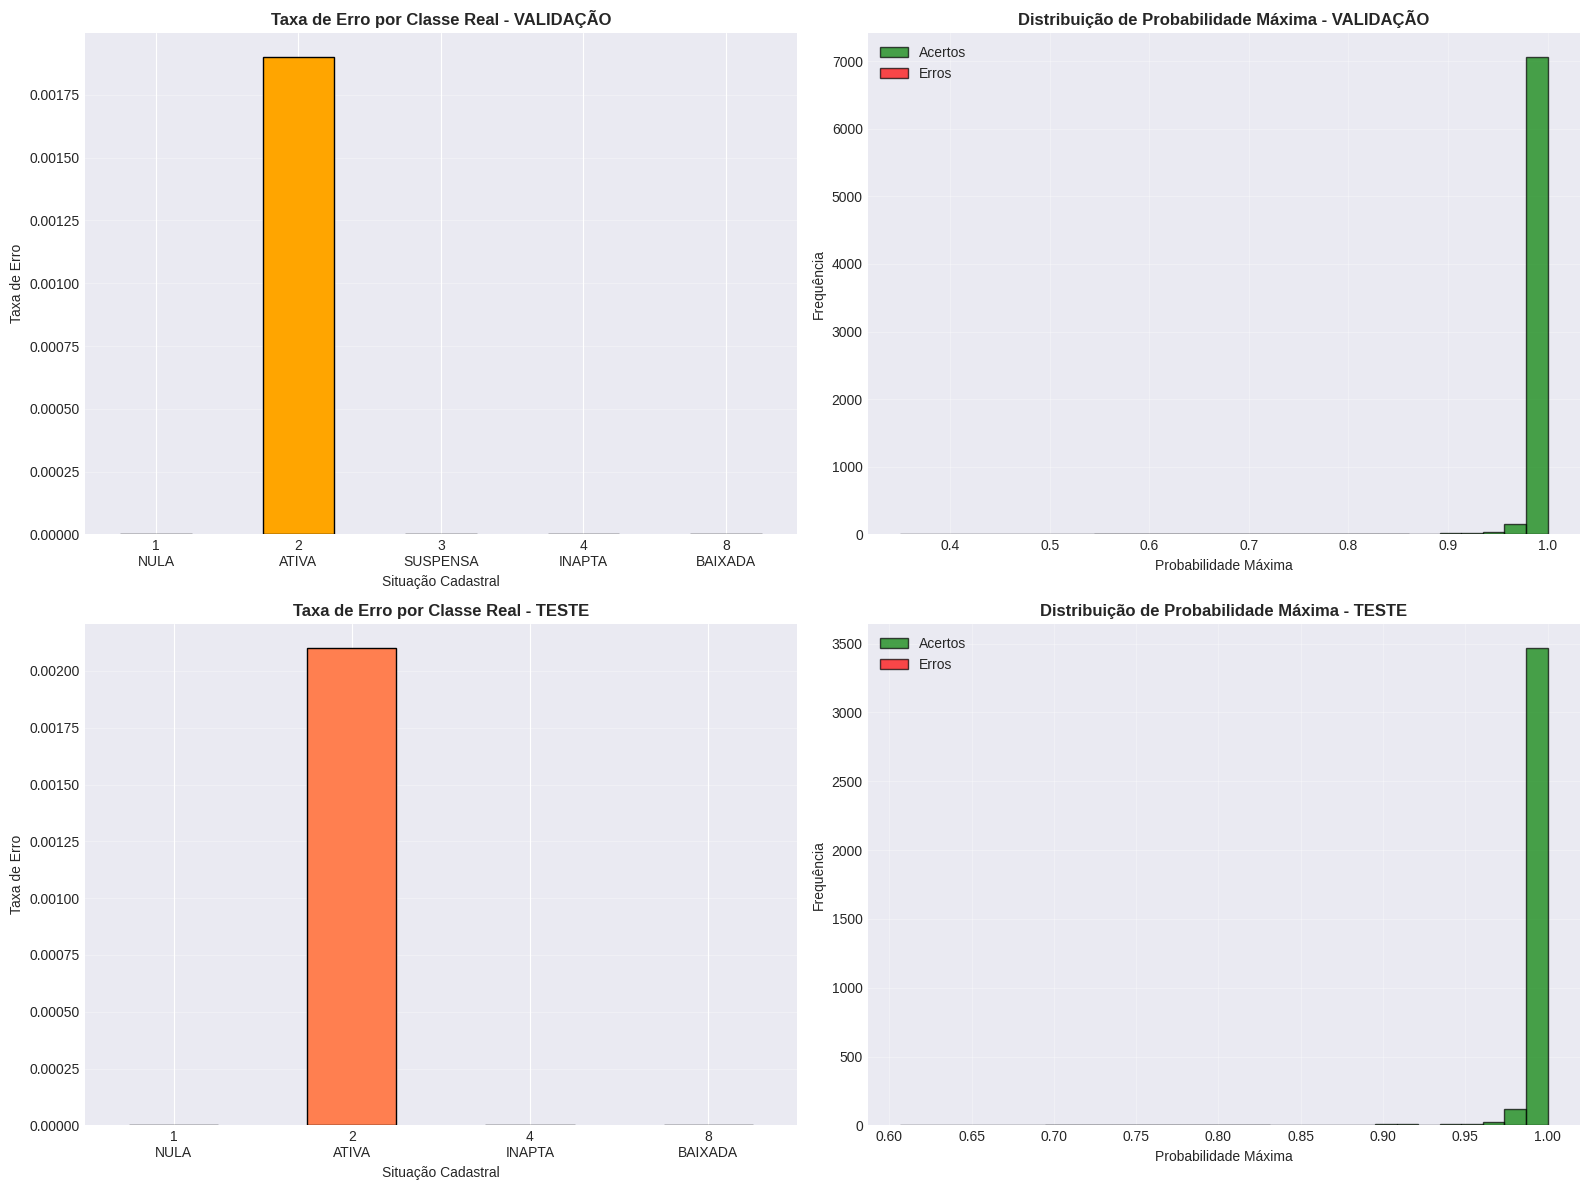

In [50]:
# Análise de erros
print("="*60)
print("ANÁLISE DE ERROS")
print("="*60)

# Cria DataFrame com resultados - VALIDAÇÃO
results_val_df = pd.DataFrame({
    'y_true': y_val.values,
    'y_pred': y_pred_val,
    'prob_max': y_pred_proba_val.max(axis=1)
})

# Adiciona informações do dataset original - VALIDAÇÃO
val_indices = df_clean.iloc[split_train_idx:split_val_idx].index
results_val_df = results_val_df.reset_index(drop=True)
results_val_df = pd.concat([
    results_val_df,
    df_clean.iloc[split_train_idx:split_val_idx][['cnpj', 'ano_mes', 'situacao_cadastral_t_minus_1']].reset_index(drop=True)
], axis=1)

# Identifica erros - VALIDAÇÃO
results_val_df['erro'] = results_val_df['y_true'] != results_val_df['y_pred']
results_val_df['acerto'] = ~results_val_df['erro']

# Cria DataFrame com resultados - TESTE
results_df = pd.DataFrame({
    'y_true': y_test.values,
    'y_pred': y_pred,
    'prob_max': y_pred_proba.max(axis=1)
})

# Adiciona informações do dataset original - TESTE
test_indices = df_clean.iloc[split_val_idx:].index
results_df = results_df.reset_index(drop=True)
results_df = pd.concat([
    results_df,
    df_clean.iloc[split_val_idx:][['cnpj', 'ano_mes', 'situacao_cadastral_t_minus_1']].reset_index(drop=True)
], axis=1)

# Identifica erros - TESTE
results_df['erro'] = results_df['y_true'] != results_df['y_pred']
results_df['acerto'] = ~results_df['erro']

print(f"\n📊 Resumo de Erros - VALIDAÇÃO:")
print(f"   Total de previsões: {len(results_val_df):,}")
print(f"   Acertos:            {results_val_df['acerto'].sum():,} ({results_val_df['acerto'].mean()*100:.2f}%)")
print(f"   Erros:              {results_val_df['erro'].sum():,} ({results_val_df['erro'].mean()*100:.2f}%)")

print(f"\n📊 Resumo de Erros - TESTE:")
print(f"   Total de previsões: {len(results_df):,}")
print(f"   Acertos:            {results_df['acerto'].sum():,} ({results_df['acerto'].mean()*100:.2f}%)")
print(f"   Erros:              {results_df['erro'].sum():,} ({results_df['erro'].mean()*100:.2f}%)")

# Análise de erros por classe - VALIDAÇÃO
print(f"\n📊 Erros por Classe Real - VALIDAÇÃO:")
print("-" * 60)
erros_por_classe_val = results_val_df.groupby('y_true').agg({
    'erro': ['sum', 'mean', 'count']
}).round(4)
erros_por_classe_val.columns = ['Total_Erros', 'Taxa_Erro', 'Total_Registros']
erros_por_classe_val['Taxa_Acerto'] = 1 - erros_por_classe_val['Taxa_Erro']
print(erros_por_classe_val)

# Análise de erros por classe - TESTE
print(f"\n📊 Erros por Classe Real - TESTE:")
print("-" * 60)
erros_por_classe = results_df.groupby('y_true').agg({
    'erro': ['sum', 'mean', 'count']
}).round(4)
erros_por_classe.columns = ['Total_Erros', 'Taxa_Erro', 'Total_Registros']
erros_por_classe['Taxa_Acerto'] = 1 - erros_por_classe['Taxa_Erro']
print(erros_por_classe)

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Taxa de erro por classe - VALIDAÇÃO
erros_por_classe_val['Taxa_Erro'].plot(kind='bar', ax=axes[0, 0], color='orange', edgecolor='black')
axes[0, 0].set_title('Taxa de Erro por Classe Real - VALIDAÇÃO', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Situação Cadastral', fontsize=10)
axes[0, 0].set_ylabel('Taxa de Erro', fontsize=10)
axes[0, 0].set_xticklabels([f"{k}\n{situacao_map.get(k, '?')}" for k in erros_por_classe_val.index], rotation=0)
axes[0, 0].grid(axis='y', alpha=0.3)

# Distribuição de probabilidade máxima - VALIDAÇÃO
axes[0, 1].hist(results_val_df[results_val_df['acerto']]['prob_max'], bins=30, alpha=0.7, 
            label='Acertos', color='green', edgecolor='black')
axes[0, 1].hist(results_val_df[results_val_df['erro']]['prob_max'], bins=30, alpha=0.7, 
            label='Erros', color='red', edgecolor='black')
axes[0, 1].set_title('Distribuição de Probabilidade Máxima - VALIDAÇÃO', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Probabilidade Máxima', fontsize=10)
axes[0, 1].set_ylabel('Frequência', fontsize=10)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Taxa de erro por classe - TESTE
erros_por_classe['Taxa_Erro'].plot(kind='bar', ax=axes[1, 0], color='coral', edgecolor='black')
axes[1, 0].set_title('Taxa de Erro por Classe Real - TESTE', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Situação Cadastral', fontsize=10)
axes[1, 0].set_ylabel('Taxa de Erro', fontsize=10)
axes[1, 0].set_xticklabels([f"{k}\n{situacao_map.get(k, '?')}" for k in erros_por_classe.index], rotation=0)
axes[1, 0].grid(axis='y', alpha=0.3)

# Distribuição de probabilidade máxima - TESTE
axes[1, 1].hist(results_df[results_df['acerto']]['prob_max'], bins=30, alpha=0.7, 
            label='Acertos', color='green', edgecolor='black')
axes[1, 1].hist(results_df[results_df['erro']]['prob_max'], bins=30, alpha=0.7, 
            label='Erros', color='red', edgecolor='black')
axes[1, 1].set_title('Distribuição de Probabilidade Máxima - TESTE', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Probabilidade Máxima', fontsize=10)
axes[1, 1].set_ylabel('Frequência', fontsize=10)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [51]:
# Resumo final
print("="*80)
print("                    RESUMO FINAL DA ANÁLISE                     ")
print("="*80)

print(f"\n📊 Dataset:")
print(f"   Total de registros: {len(df):,}")
print(f"   CNPJs únicos: {df['cnpj'].nunique():,}")
print(f"   Período: {df['ano_mes'].min().strftime('%Y-%m')} a {df['ano_mes'].max().strftime('%Y-%m')}")
print(f"   Registros após limpeza: {len(df_clean):,}")

print(f"\n📊 Divisão dos Dados:")
print(f"   Treino:     {len(X_train):,} registros (70.0%)")
print(f"   Validação:  {len(X_val):,} registros (20.0%)")
print(f"   Teste:      {len(X_test):,} registros (10.0%)")

print(f"\n🔧 Features:")
print(f"   Features criadas: {len(new_features)}")
print(f"   Features finais utilizadas: {len(feature_cols)}")

print(f"\n🤖 Modelo:")
print(f"   Algoritmo: Random Forest")
print(f"\n   Métricas - VALIDAÇÃO:")
print(f"      Acurácia:        {accuracy_val:.4f} ({accuracy_val*100:.2f}%)")
print(f"      F1-Score (macro): {f1_macro_val:.4f}")
print(f"      F1-Score (weighted): {f1_weighted_val:.4f}")
print(f"\n   Métricas - TESTE:")
print(f"      Acurácia:        {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"      F1-Score (macro): {f1_macro:.4f}")
print(f"      F1-Score (weighted): {f1_weighted:.4f}")

print(f"\n📈 Top 5 Features Mais Importantes:")
for i, row in feature_importance.head(5).iterrows():
    print(f"   {i+1}. {row['feature']:45s}: {row['importance']:.4f}")

print(f"\n✅ Análise concluída!")
print("="*80)


                    RESUMO FINAL DA ANÁLISE                     

📊 Dataset:
   Total de registros: 65,855
   CNPJs únicos: 4,839
   Período: 2023-06 a 2024-12
   Registros após limpeza: 36,737

📊 Divisão dos Dados:
   Treino:     25,715 registros (70.0%)
   Validação:  7,348 registros (20.0%)
   Teste:      3,674 registros (10.0%)

🔧 Features:
   Features criadas: 28
   Features finais utilizadas: 33

🤖 Modelo:
   Algoritmo: Random Forest

   Métricas - VALIDAÇÃO:
      Acurácia:        0.9993 (99.93%)
      F1-Score (macro): 0.9995
      F1-Score (weighted): 0.9993

   Métricas - TESTE:
      Acurácia:        0.9992 (99.92%)
      F1-Score (macro): 0.9992
      F1-Score (weighted): 0.9992

📈 Top 5 Features Mais Importantes:
   24. situacao_cadastral_rolling_mean_3            : 0.1499
   20. situacao_cadastral_lag_1                     : 0.1367
   25. situacao_cadastral_rolling_mean_6            : 0.1311
   9. situacao_cadastral_t_minus_1                 : 0.1289
   21. situacao_cadas